# Credit to Shreya Kapoor, https://github.com/ShreyaKapoor18/BCI_Neurotech

In [1]:

#%%
import mne
import os.path as op

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
#from mne_bids import BIDSPath, read_raw_bids/
from scipy.io import loadmat
import mne
from mne.viz import plot_alignment, snapshot_brain_montage
from mne.time_frequency import fit_iir_model_raw
import gc
from scipy import signal
gc.enable()

col_names = [f'CH_{i}' for i in range(1, 61)]
col_names.extend(['paradigm_info'])
print(len(col_names))
sampling_freq = 1200
ch_types =['misc'] + ['ecog'] * 60 + ['stim']

info = mne.create_info(ch_names=["time"] + col_names, ch_types=ch_types, sfreq=sampling_freq)
# Load the data
data = loadmat("ECoG_Handpose.mat")['y']
# Index 1-60 means channels 2-61
raw = mne.io.RawArray(data[0:62,:], info) # we dont need the first channel
gc.collect()

raw.load_data().resample(sampling_freq )  #nyquist theorem
events = mne.find_events(raw, stim_channel="paradigm_info")
print(events)
raw.pick_types(ecog=True)
#%%
event_id = dict( fist_movement = 1 , peace_movement = 2 , open_hand = 3 )



61
Creating RawArray with float64 data, n_channels=62, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.
90 events found
Event IDs: [1 2 3]
90 events found
Event IDs: [1 2 3]
90 events found
Event IDs: [1 2 3]
[[ 14496      0      3]
 [ 20256      0      1]
 [ 26112      0      3]
 [ 31680      0      2]
 [ 37440      0      2]
 [ 43056      0      3]
 [ 48000      0      3]
 [ 53760      0      2]
 [ 58896      0      3]
 [ 64320      0      1]
 [ 69792      0      2]
 [ 75264      0      2]
 [ 81120      0      2]
 [ 86256      0      3]
 [ 91200      0      2]
 [ 97056      0      2]
 [102768      0      1]
 [108192      0      2]
 [113568      0      3]
 [118608      0      1]
 [123888      0      2]
 [128928      0      3]
 [134640      0      3]
 [139632      0      3]
 [144768      0      1]
 [150336      0      2]
 [155568      0      1]
 [161232      0      1]
 [167040      0      2]
 [172368      0      3]
 [177408      0      2]
 [183216      0  

In [2]:
timings = data[0,:]
delta_t = timings[1] - timings[0]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 3961 samples (3.301 sec)

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.
Setting up band-stop filter from 48 - 52 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 48.50
- Lower transiti

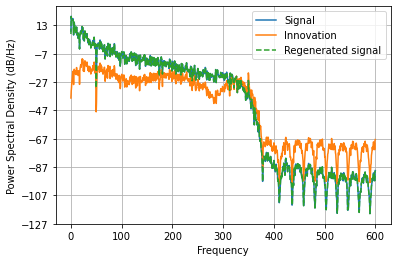

In [3]:

#%%
'''
After excluding channels that were notably bad due to
high impedance, we re-referenced the data by the common
average. After that, a notch-filter cascade (recursive 6th-order
Butterworth, bandwidth: 5 Hz) up to the 6th harmonic was
used to remove interference peaks from the spectrum at integer
multiples of the power line frequency'''

# They set the trial length to 0.75 seconds pre- and post-onset, respectively
# full_mean = raw._data.mean(axis=0)
#mean_col =# get the meaning of the column
# raw._data -= full_mean # this could cause bias though
raw.filter(1, 300)
# raw.filter(1, None)
raw.set_eeg_reference("average")
nf = 50
raw.notch_filter([nf], notch_widths=2, trans_bandwidth=1)  # raw.notch_filter([60], trans_bandwidth=5)


#picks = mne.pick_types(raw.info, meg='grad', exclude='bads')

order = 5  # define model order
#picks = picks[:1]

# from https://mne.tools/stable/auto_examples//time_frequency/temporal_whitening.html#sphx-glr-auto-examples-time-frequency-temporal-whitening-py
# Estimate AR models on raw data
b, a = fit_iir_model_raw(raw, order=order, picks=["ecog"], tmin=timings[0], tmax=timings[-1])
d, times = raw[0, 10000:20000]  # look at one channel from now on
d = d.ravel()  # make flat vector
innovation = signal.convolve(d, a, "valid")
d_ = signal.lfilter(b, a, innovation)  # regenerate the signal
d_ = np.r_[d_[0] * np.ones(order), d_]  # dummy samples to keep signal length

# plt.close('all')
# plt.figure()
# plt.plot(d[:100], label='signal')
# plt.plot(d_[:100], label='regenerated signal')
# plt.legend()

plt.figure()
plt.psd(d, Fs=raw.info['sfreq'], NFFT=2048)
plt.psd(innovation, Fs=raw.info['sfreq'], NFFT=2048)
plt.psd(d_, Fs=raw.info['sfreq'], NFFT=2048, linestyle='--')
plt.legend(('Signal', 'Innovation', 'Regenerated signal'))
plt.show()
#%%
#raw.plot()
#plt.savefig('results/mne_plot.png')
#picks=['CH_5', 'CH_10', 'CH_15']

#raw.plot_psd(average=True)
#plt.savefig('results/plot_spectral_density.png')

#plt.savefig('results/ecog.png')
#raw.plot_sensors(ch_type='ecog')

# Then we remove line frequency interference



In [5]:
# raw.filter?

In [6]:
m = raw._data
m.mean(), m.std(), m.shape

(-8.419765703696779e-15, 831.8760136558976, (60, 507025))

Effective window size : 1.707 (s)


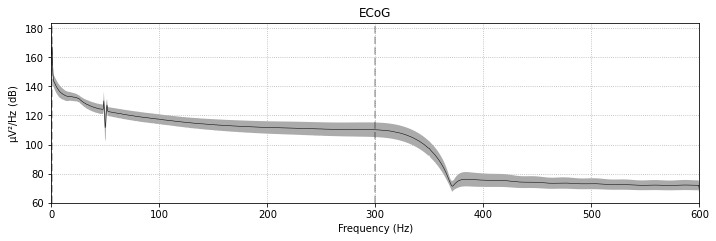

0

In [7]:
raw.plot_psd(average=True)
0

In [8]:
# raw._data /= raw._data.max()

In [11]:
epochs = mne.Epochs(raw, events, tmin=0., tmax=1.5, baseline=(0, 0))
print(epochs)

Not setting metadata
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
<Epochs |  90 events (good & bad), 0 - 1.5 sec, baseline 0 – 0 sec, ~60 kB, data not loaded,
 '1': 30
 '2': 30
 '3': 30>


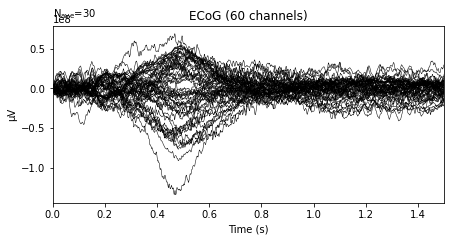

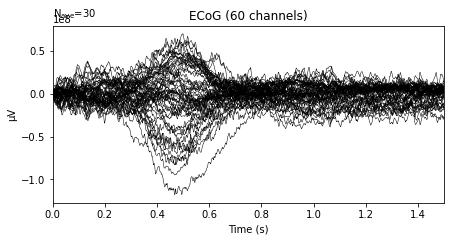

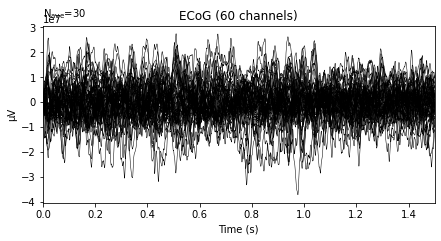

In [14]:
for i in '123':
    epochs[i].average().plot()

In [15]:
import mne.decoding


# for n_components in range(1, 30):
# lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
csp = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
# clf = sklearn.pipeline.Pipeline([('CSP', csp), ('LDA', lda)])
# scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
# class_balance = np.mean(labels == labels[0])
# class_balance = max(class_balance, 1. - class_balance)
# print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
#                                                           class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit(epochs.get_data(), epochs.events[:, -1])

# csp.plot_patterns(epochs.info, ch_type='ecog', units='Patterns (AU)', size=1.5)
# plt.show()

Loading data for 90 events and 1801 original time points ...
Computing rank from data with rank=None
    Using tolerance 5.4e+02 (2.2e-16 eps * 60 dim * 4.1e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.3e+02 (2.2e-16 eps * 60 dim * 4e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e+02 (2.2e-16 eps * 60 dim * 3.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigen

CSP(component_order='mutual_info', cov_est='concat', cov_method_params=None,
  log=True, n_components=4, norm_trace=False, rank=None, reg=None,
  transform_into='average_power')

In [16]:
# To be used
csp_cache = {}
model_cache = {}

In [17]:
group_cache = {"csp": csp_cache}

In [18]:
predictor_cache = {}

In [33]:
from tqdm.auto import tqdm, trange
import random


random.seed(16)
data = epochs.get_data()
n_splits = 16
n_folds = 3
fold_size = len(data) // n_folds
folds = []
for s in trange(n_splits):
    fold = []
    ts = list(range(len(data)))
    random.shuffle(ts)
    for i in range(0, len(data), fold_size):
        x = data[ts][i:i+fold_size]
        y = epochs.events[ts][i:i+fold_size, -1]
        fold.append((x, y))
    folds.append(fold)

Loading data for 90 events and 1801 original time points ...


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

DummyClassifier()


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 26.4583±2.6707
percentage_accuracy_score: 26.4583


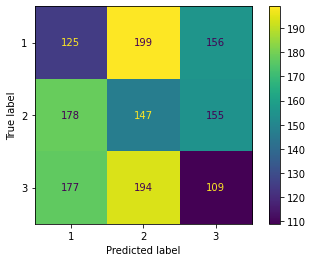





Pipeline(steps=[('xdawn', XdawnCovariances(estimator='oas')), ('mdm', MDM())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 94.4097±2.8360
percentage_accuracy_score: 94.5238


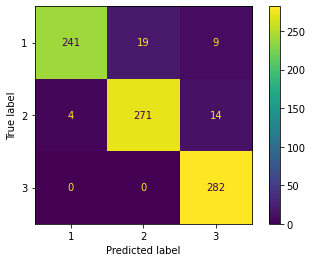





Pipeline(steps=[('xdawn', XdawnCovariances(estimator='oas', nfilter=2)),
                ('mdm', MDM())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 95.2083±2.6196
percentage_accuracy_score: 95.7143


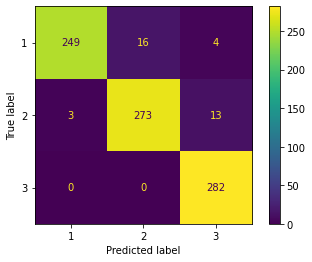





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas')),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 91.5079±4.0195
percentage_accuracy_score: 91.6667


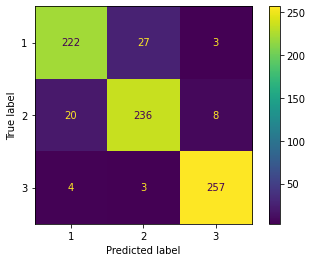





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas')),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 30.9524±11.0103
percentage_accuracy_score: 30.2564


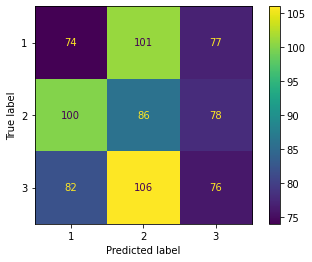





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas')),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 92.2222±3.3399
percentage_accuracy_score: 92.5641


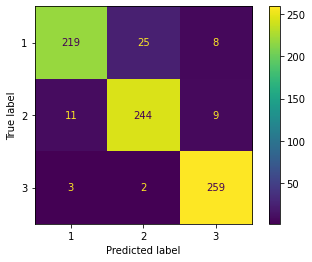





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas')),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 77.5794±13.8294
percentage_accuracy_score: 77.0513


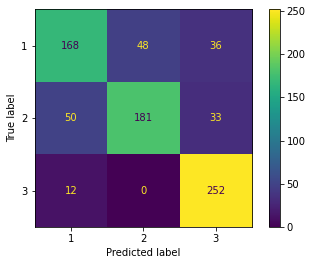





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas', nfilter=2)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 69.7222±8.7634
percentage_accuracy_score: 70.3846


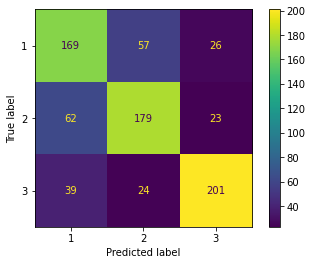





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas', nfilter=2)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 30.8333±11.0290
percentage_accuracy_score: 30.1282


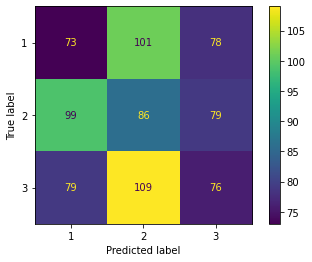





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas', nfilter=2)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 93.0952±3.7780
percentage_accuracy_score: 93.4615


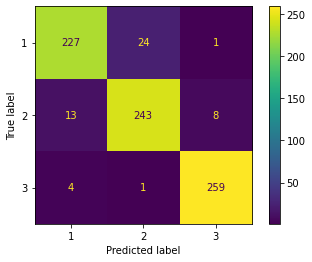





Pipeline(steps=[('scaler', AllScaler()),
                ('prep', XdawnCovariances(estimator='oas', nfilter=2)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 78.7698±15.5189
percentage_accuracy_score: 77.9487


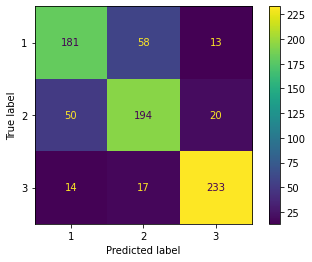





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0', XdawnCovariances(estimator='oas')),
                                      ('1',
                                       FeatureUnion(transformer_list=[('40hz',
                                                                       CachedPredictor(model=BandPower(high=100,
                                                                                                       low=40))),
                                                                      ('80hz',
                                                                       CachedPredictor(model=BandPower(high=140,
                                                                                                       low=80))),
                                                                      ('120hz',
                                                                       CachedPredictor(model=BandPower(high=180,
 

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 93.0556±2.7599
percentage_accuracy_score: 92.9487


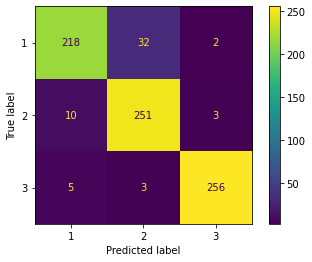





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0', XdawnCovariances(estimator='oas')),
                                      ('1',
                                       FeatureUnion(transformer_list=[('40hz',
                                                                       CachedPredictor(model=BandPower(high=100,
                                                                                                       low=40))),
                                                                      ('80hz',
                                                                       CachedPredictor(model=BandPower(high=140,
                                                                                                       low=80))),
                                                                      ('120hz',
                                                                       CachedPredictor(model=BandPower(high=180,
 

  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

accuracy: 93.2143±4.2527
percentage_accuracy_score: 93.0769


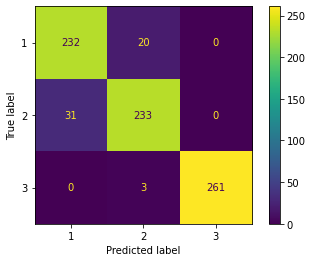





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0', XdawnCovariances(estimator='oas')),
                                      ('1',
                                       FeatureUnion(transformer_list=[('40hz',
                                                                       CachedPredictor(model=BandPower(high=100,
                                                                                                       low=40))),
                                                                      ('80hz',
                                                                       CachedPredictor(model=BandPower(high=140,
                                                                                                       low=80))),
                                                                      ('120hz',
                                                                       CachedPredictor(model=BandPower(high=180,
 

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 93.5317±4.1394
percentage_accuracy_score: 93.7179


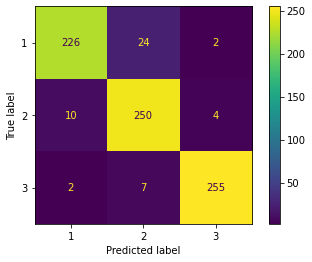





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0', XdawnCovariances(estimator='oas')),
                                      ('1',
                                       FeatureUnion(transformer_list=[('40hz',
                                                                       CachedPredictor(model=BandPower(high=100,
                                                                                                       low=40))),
                                                                      ('80hz',
                                                                       CachedPredictor(model=BandPower(high=140,
                                                                                                       low=80))),
                                                                      ('120hz',
                                                                       CachedPredictor(model=BandPower(high=180,
 

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 52.5794±11.9847
percentage_accuracy_score: 52.0513


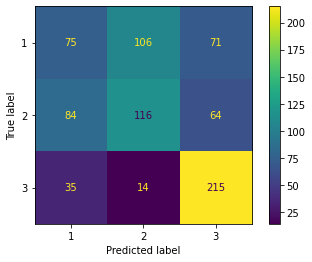





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedPredictor(model=CachedTrainer(group='topo',
                                                                           invariant=True,
                                                                           kwargs={},
                                                                           model_lambda=<function <lambda> at 0x7fe93efe2790>))),
                                      ('1',
                                       FeatureUnion(transformer_list=[('40hz',
                                                                       CachedPredictor(model=BandPower(high=100,
                                                                                                       low=40))),
                                                                      ('80hz',
                                                             

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 86.3889±2.6498
percentage_accuracy_score: 86.3889


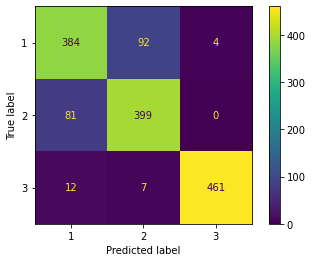





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedPredictor(model=CachedTrainer(group='topo',
                                                                           invariant=True,
                                                                           kwargs={},
                                                                           model_lambda=<function <lambda> at 0x7fe93efe2790>))),
                                      ('1',
                                       FeatureUnion(transformer_list=[('40hz',
                                                                       CachedPredictor(model=BandPower(high=100,
                                                                                                       low=40))),
                                                                      ('80hz',
                                                             

  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

accuracy: 77.5000±4.0919
percentage_accuracy_score: 77.5000


/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


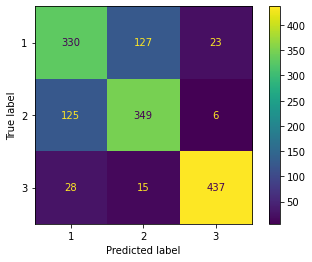





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedPredictor(model=CachedTrainer(group='topo',
                                                                           invariant=True,
                                                                           kwargs={},
                                                                           model_lambda=<function <lambda> at 0x7fe93efe2790>))),
                                      ('1',
                                       FeatureUnion(transformer_list=[('40hz',
                                                                       CachedPredictor(model=BandPower(high=100,
                                                                                                       low=40))),
                                                                      ('80hz',
                                                             

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 83.4028±4.0152
percentage_accuracy_score: 83.4028


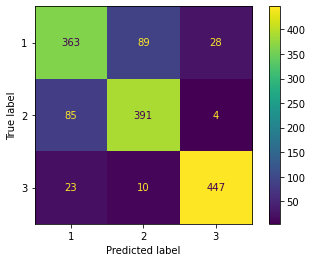





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedPredictor(model=CachedTrainer(group='topo',
                                                                           invariant=True,
                                                                           kwargs={},
                                                                           model_lambda=<function <lambda> at 0x7fe93efe2790>))),
                                      ('1',
                                       FeatureUnion(transformer_list=[('40hz',
                                                                       CachedPredictor(model=BandPower(high=100,
                                                                                                       low=40))),
                                                                      ('80hz',
                                                             

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 44.6528±8.4366
percentage_accuracy_score: 44.6528


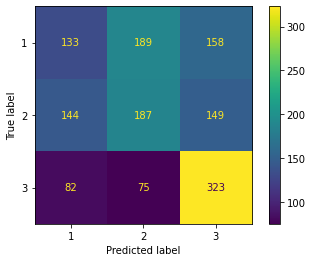





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedPredictor(model=CachedTrainer(group='topo',
                                                     invariant=True, kwargs={},
                                                     model_lambda=<function <lambda> at 0x7fe93efe2790>))),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 32.3611±3.8665
percentage_accuracy_score: 32.3611


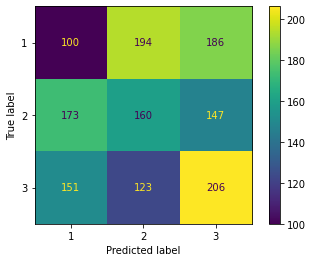





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedPredictor(model=CachedTrainer(group='topo',
                                                     invariant=True, kwargs={},
                                                     model_lambda=<function <lambda> at 0x7fe93efe2790>))),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

accuracy: 32.6389±3.4219
percentage_accuracy_score: 32.6389


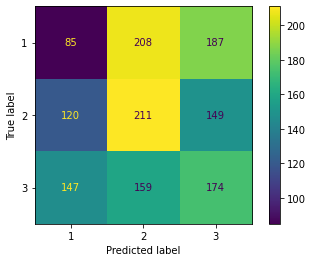





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedPredictor(model=CachedTrainer(group='topo',
                                                     invariant=True, kwargs={},
                                                     model_lambda=<function <lambda> at 0x7fe93efe2790>))),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 30.6250±4.5638
percentage_accuracy_score: 30.6250


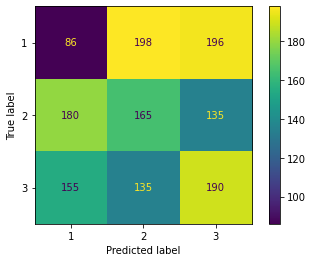





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedPredictor(model=CachedTrainer(group='topo',
                                                     invariant=True, kwargs={},
                                                     model_lambda=<function <lambda> at 0x7fe93efe2790>))),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 32.5694±3.9620
percentage_accuracy_score: 32.5694


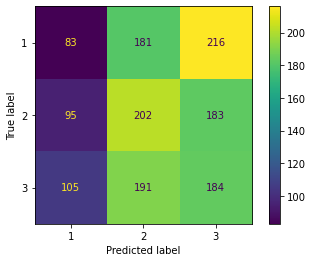





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('40hz',
                                                 CachedPredictor(model=BandPower(high=100,
                                                                                 low=40))),
                                                ('80hz',
                                                 CachedPredictor(model=BandPower(high=140,
                                                                                 low=80))),
                                                ('120hz',
                                                 CachedPredictor(model=BandPower(high=180,
                                                                                 low=120))),
                                                ('160hz',
                                                 CachedPredictor(model=BandPower(high=220,
                                                           

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 89.6528±2.3804
percentage_accuracy_score: 89.6528


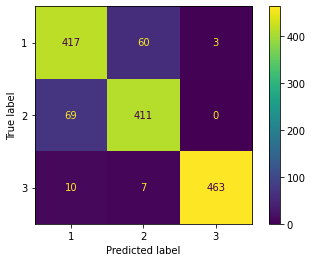





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('40hz',
                                                 CachedPredictor(model=BandPower(high=100,
                                                                                 low=40))),
                                                ('80hz',
                                                 CachedPredictor(model=BandPower(high=140,
                                                                                 low=80))),
                                                ('120hz',
                                                 CachedPredictor(model=BandPower(high=180,
                                                                                 low=120))),
                                                ('160hz',
                                                 CachedPredictor(model=BandPower(high=220,
                                                           

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 92.0833±4.0801
percentage_accuracy_score: 92.0833


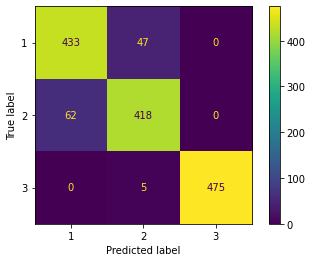





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('40hz',
                                                 CachedPredictor(model=BandPower(high=100,
                                                                                 low=40))),
                                                ('80hz',
                                                 CachedPredictor(model=BandPower(high=140,
                                                                                 low=80))),
                                                ('120hz',
                                                 CachedPredictor(model=BandPower(high=180,
                                                                                 low=120))),
                                                ('160hz',
                                                 CachedPredictor(model=BandPower(high=220,
                                                           

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 84.7917±5.2370
percentage_accuracy_score: 84.7917


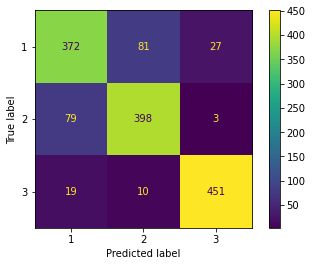





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(transformer_list=[('40hz',
                                                 CachedPredictor(model=BandPower(high=100,
                                                                                 low=40))),
                                                ('80hz',
                                                 CachedPredictor(model=BandPower(high=140,
                                                                                 low=80))),
                                                ('120hz',
                                                 CachedPredictor(model=BandPower(high=180,
                                                                                 low=120))),
                                                ('160hz',
                                                 CachedPredictor(model=BandPower(high=220,
                                                           

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 52.5694±9.0499
percentage_accuracy_score: 52.5694


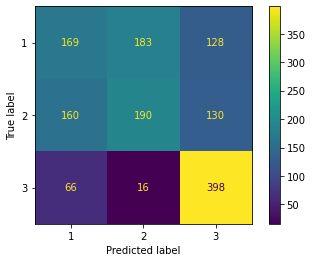





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 4},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe25e0>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 51.4583±5.6889
percentage_accuracy_score: 51.4583


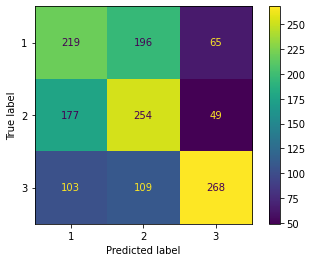





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 4},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe25e0>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 48.4028±5.1064
percentage_accuracy_score: 48.4028


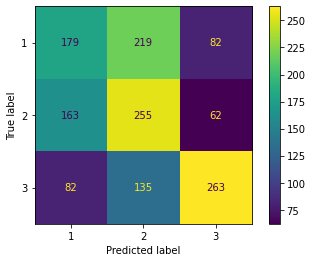





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 4},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe25e0>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 49.3750±4.4957
percentage_accuracy_score: 49.3750


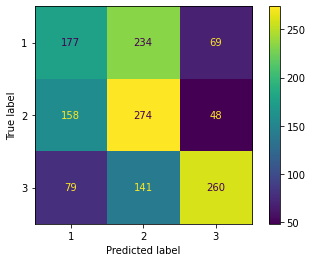





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 4},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe25e0>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 49.7917±5.3607
percentage_accuracy_score: 49.7917


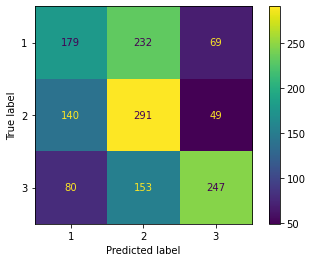





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 8},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ee0>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 52.8472±5.3715
percentage_accuracy_score: 52.8472


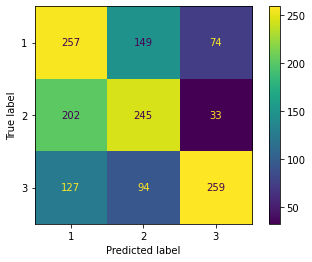





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 8},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ee0>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 48.8889±5.4575
percentage_accuracy_score: 48.8889


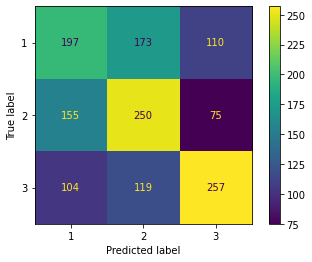





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 8},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ee0>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 51.4583±5.3391
percentage_accuracy_score: 51.4583


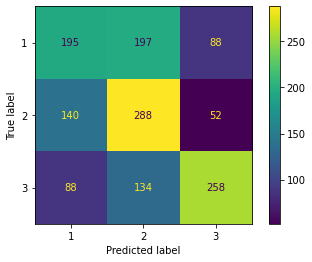





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 8},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ee0>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 50.7639±4.9802
percentage_accuracy_score: 50.7639


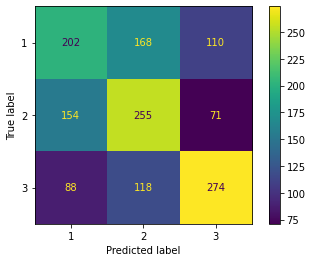





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe21f0>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 52.4306±5.7227
percentage_accuracy_score: 52.4306


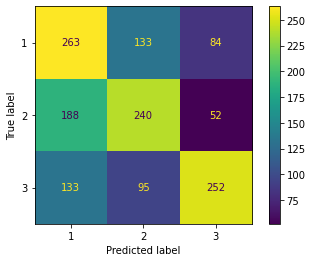





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe21f0>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 48.6111±3.9185
percentage_accuracy_score: 48.6111


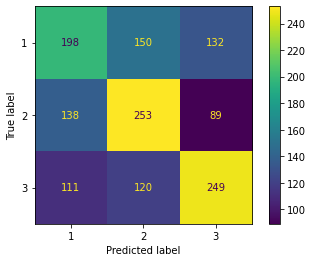





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe21f0>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 50.2778±5.4786
percentage_accuracy_score: 50.2778


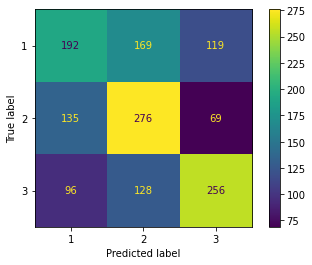





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe21f0>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 48.8889±6.8606
percentage_accuracy_score: 48.8889


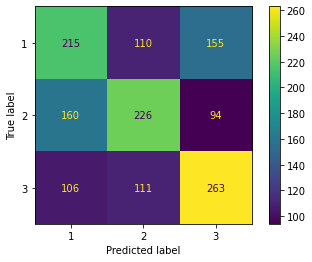





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 16},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2940>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 53.2639±4.5723
percentage_accuracy_score: 53.2639


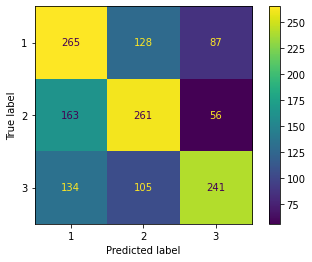





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 16},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2940>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 48.7500±5.5815
percentage_accuracy_score: 48.7500


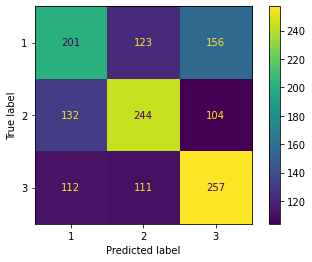





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 16},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2940>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 50.9028±5.7631
percentage_accuracy_score: 50.9028


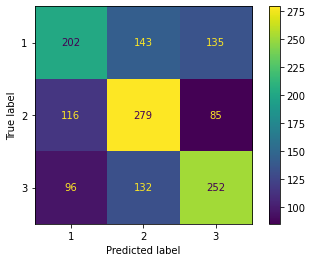





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 16},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2940>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 47.8472±3.6740
percentage_accuracy_score: 47.8472


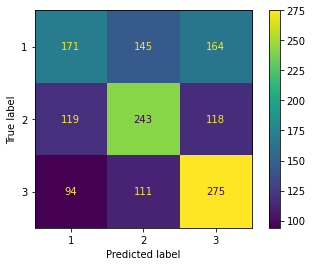





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 20},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ca0>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 51.1111±4.5812
percentage_accuracy_score: 51.1111


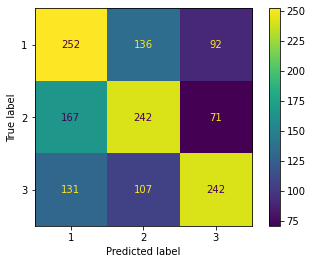





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 20},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ca0>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 48.7500±5.9690
percentage_accuracy_score: 48.7500


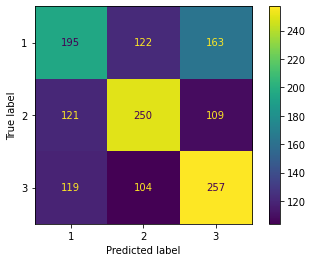





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 20},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ca0>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 51.5972±6.6663
percentage_accuracy_score: 51.5972


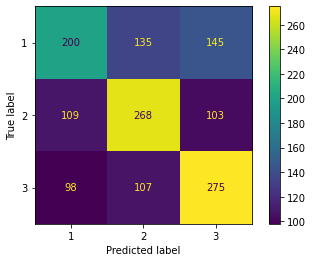





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 20},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ca0>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 48.8889±5.4433
percentage_accuracy_score: 48.8889


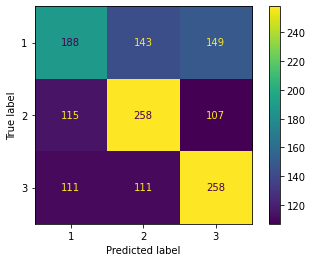





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 24},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2b80>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 51.1806±3.7365
percentage_accuracy_score: 51.1806


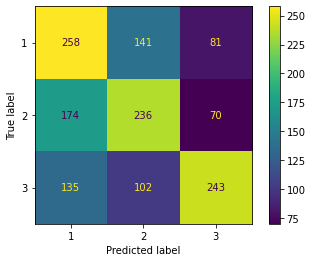





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 24},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2b80>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 50.6944±5.4415
percentage_accuracy_score: 50.6944


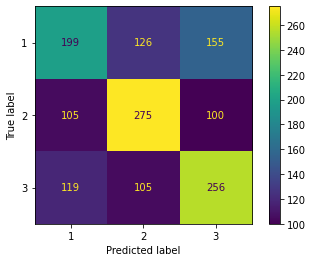





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 24},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2b80>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 51.7361±5.0303
percentage_accuracy_score: 51.7361


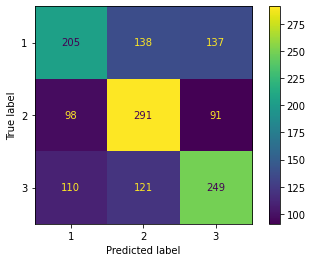





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 24},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2b80>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 49.5139±4.4265
percentage_accuracy_score: 49.5139


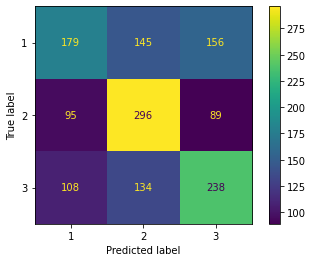





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 28},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2a60>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 50.6944±4.7120
percentage_accuracy_score: 50.6944


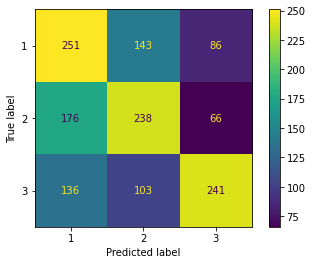





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 28},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2a60>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 50.2778±6.6260
percentage_accuracy_score: 50.2778


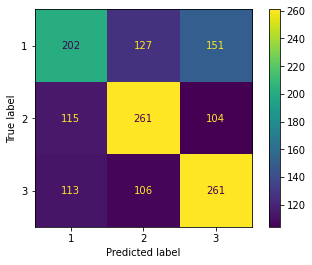





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 28},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2a60>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 50.6250±6.3217
percentage_accuracy_score: 50.6250


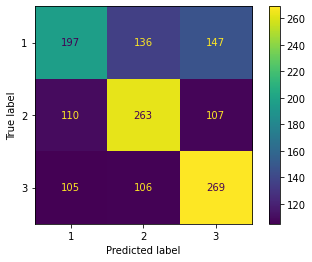





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 28},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2a60>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 48.5417±6.1202
percentage_accuracy_score: 48.5417


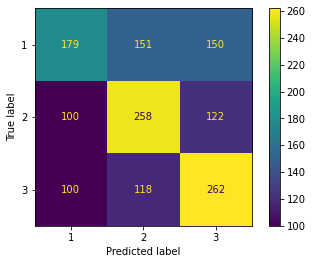





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe21f0>)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 52.4306±5.7227
percentage_accuracy_score: 52.4306


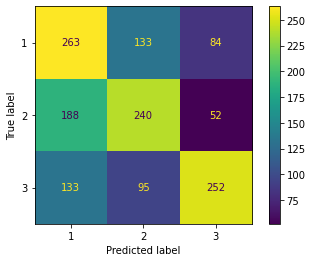





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe21f0>)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 48.6111±3.9185
percentage_accuracy_score: 48.6111


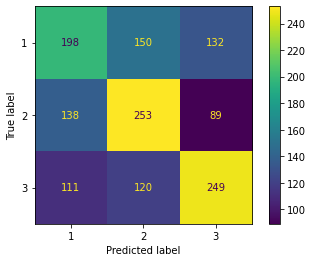





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe21f0>)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 50.2778±5.4786
percentage_accuracy_score: 50.2778


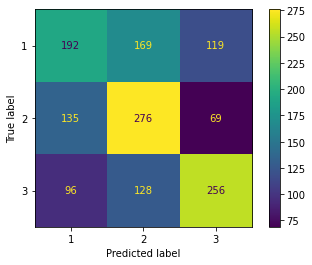





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe21f0>)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 48.8889±6.8606
percentage_accuracy_score: 48.8889


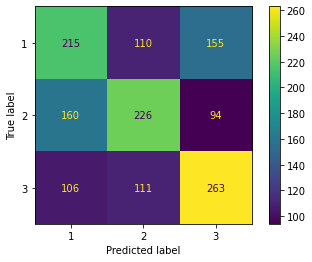





Pipeline(steps=[('scaler', AllScaler()), ('prep', ERPFeature(window=20)),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 64.5833±4.1551
percentage_accuracy_score: 64.5833


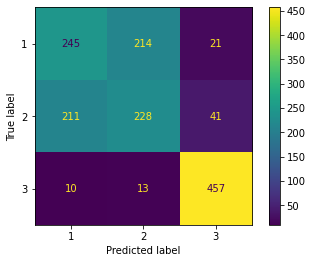





Pipeline(steps=[('scaler', AllScaler()), ('prep', ERPFeature(window=20)),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

accuracy: 76.8750±3.2918
percentage_accuracy_score: 76.8750


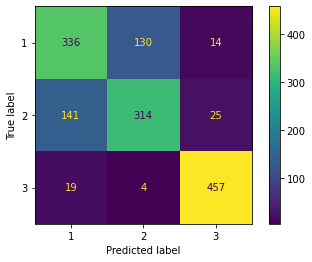





Pipeline(steps=[('scaler', AllScaler()), ('prep', ERPFeature(window=20)),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 75.0694±3.3326
percentage_accuracy_score: 75.0694


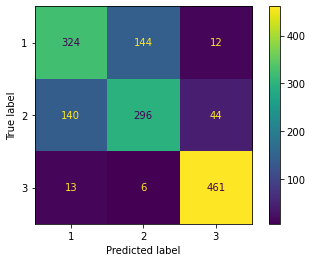





Pipeline(steps=[('scaler', AllScaler()), ('prep', ERPFeature(window=20)),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 57.9167±3.4667
percentage_accuracy_score: 57.9167


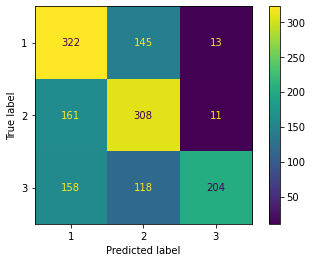





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 4},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe25e0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 64.7222±3.9772
percentage_accuracy_score: 64.7222


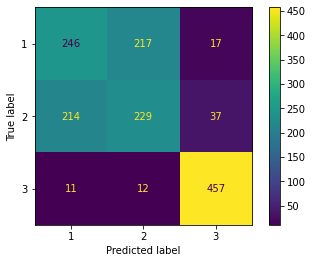





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 4},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe25e0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 77.1528±3.3326
percentage_accuracy_score: 77.1528


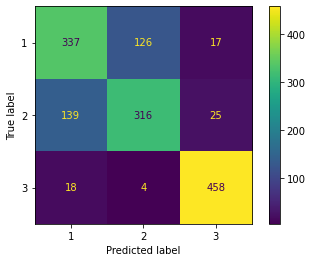





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 4},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe25e0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 74.9306±3.8081
percentage_accuracy_score: 74.9306


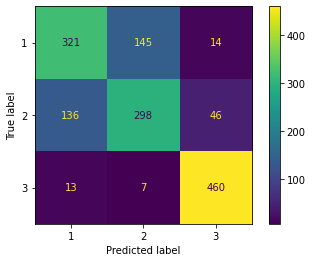





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 4},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe25e0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 61.8056±4.5622
percentage_accuracy_score: 61.8056


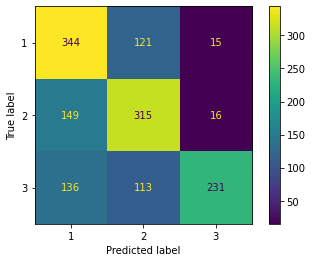





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 8},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ee0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 64.7917±4.4569
percentage_accuracy_score: 64.7917


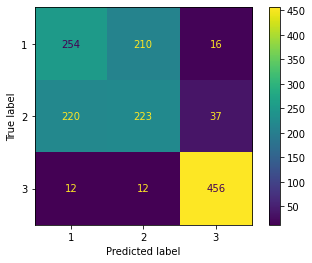





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 8},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ee0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 77.6389±3.7654
percentage_accuracy_score: 77.6389


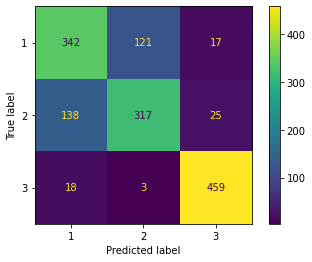





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 8},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ee0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 75.6944±4.0612
percentage_accuracy_score: 75.6944


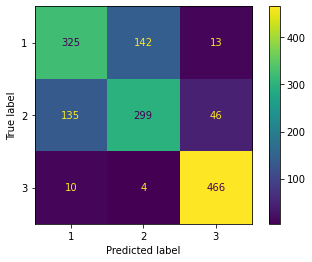





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 8},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ee0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 61.7361±5.8790
percentage_accuracy_score: 61.7361


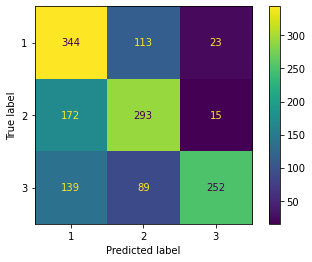





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 12},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe21f0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 64.5139±5.0072
percentage_accuracy_score: 64.5139


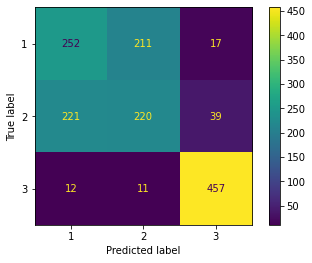





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 12},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe21f0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 78.4722±3.4219
percentage_accuracy_score: 78.4722


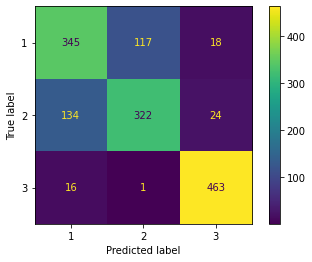





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 12},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe21f0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 76.3194±3.7210
percentage_accuracy_score: 76.3194


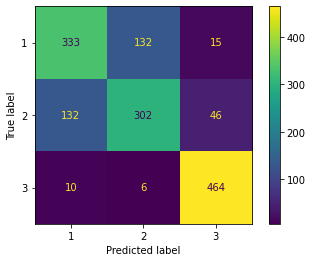





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 12},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe21f0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 61.6667±4.5134
percentage_accuracy_score: 61.6667


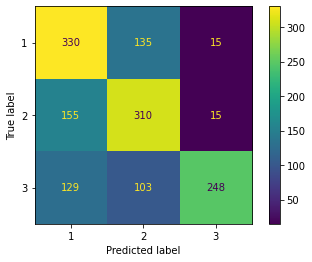





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 16},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2940>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 64.2361±5.6276
percentage_accuracy_score: 64.2361


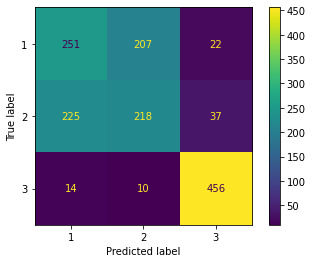





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 16},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2940>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 78.8194±3.1542
percentage_accuracy_score: 78.8194


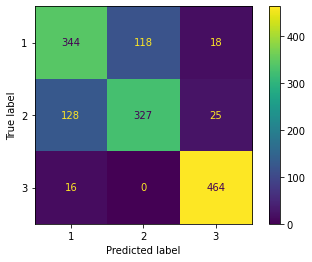





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 16},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2940>)),
                                      ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 76.5278±3.6825
percentage_accuracy_score: 76.5278


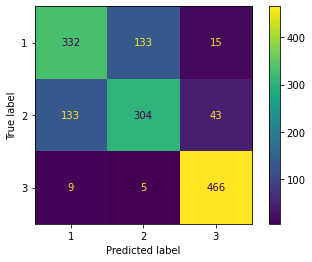





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 16},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2940>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 61.8056±4.1551
percentage_accuracy_score: 61.8056


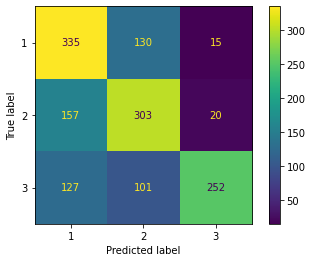





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 20},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ca0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 64.0972±4.9647
percentage_accuracy_score: 64.0972


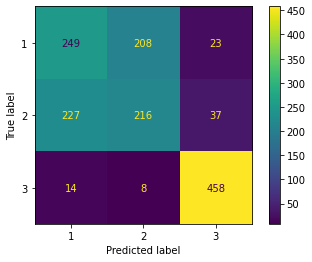





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 20},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ca0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 78.7500±3.0650
percentage_accuracy_score: 78.7500


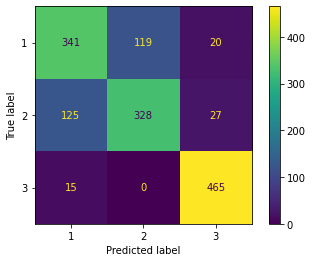





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 20},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ca0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 76.8056±3.7242
percentage_accuracy_score: 76.8056


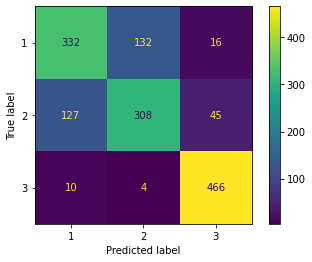





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 20},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2ca0>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 62.7778±3.9087
percentage_accuracy_score: 62.7778


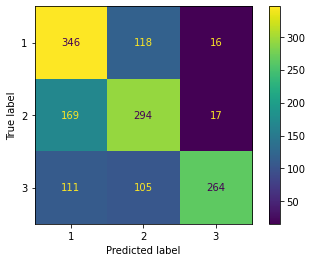





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 24},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2b80>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 64.1667±4.6729
percentage_accuracy_score: 64.1667


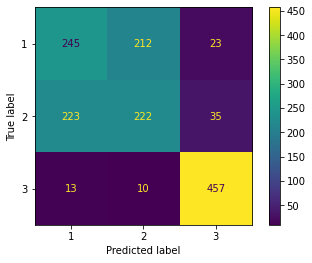





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 24},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2b80>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

/home/ax37/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy: 78.6111±3.3449
percentage_accuracy_score: 78.6111


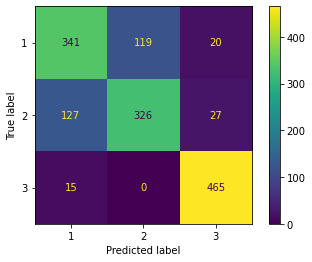





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 24},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2b80>)),
                                      ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 76.8056±3.5762
percentage_accuracy_score: 76.8056


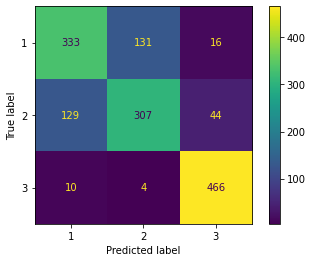





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 24},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2b80>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=SGDClassifier()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 63.8889±6.2361
percentage_accuracy_score: 63.8889


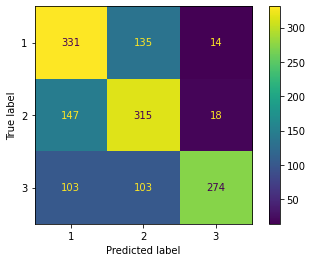





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 28},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2a60>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LinearDiscriminantAnalysis()))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 64.0278±5.1501
percentage_accuracy_score: 64.0278


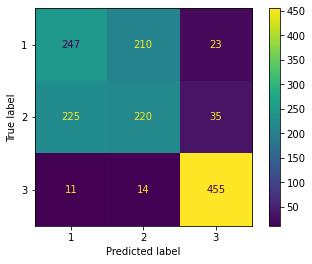





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 28},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2a60>)),
                                      ('1', ERPFeature(window=20))])),
                ('model', Model3D(model=LogisticRegression(C=0.1)))])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 78.5417±3.1111
percentage_accuracy_score: 78.5417


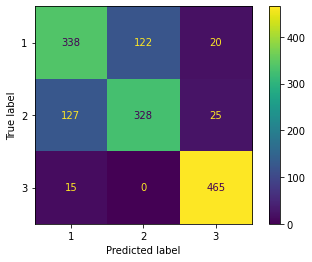





Pipeline(steps=[('scaler', AllScaler()),
                ('prep',
                 FeatureUnion(models=[('0',
                                       CachedTrainer(group='csp',
                                                     kwargs={'n_components': 28},
                                                     model_lambda=<function <listcomp>.<lambda> at 0x7fe93efe2a60>)),
                                      ('1', ERPFeature(window=20))])),
                ('model',
                 Model3D(model=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('model',
                                                LogisticRegression())])))])


  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
import sklearn.discriminant_analysis
import sklearn.linear_model
import sklearn.ensemble
import sklearn.pipeline
import sklearn.dummy
import scipy.signal
import pandas as pd
import contextlib
import io

import pyriemann # from catboost import CatboostClassifier

from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Amplitude, NumberOfPoints, PersistenceEntropy


def percentage_accuracy_score(*args, **kwargs):
    return 100 * sklearn.metrics.accuracy_score(*args, *kwargs)


def hash_xy(x, y):
    return hash((str(x), str(y)))

    
def wrap_list(x):
    try:
        len(x)
    except TypeError:
        x = [x]
    return x


def uni_concat(xs):
    if not xs:
        return
    if isinstance(xs[0], list):
        return sum(xs, [])
    else:
        try:
            return pd.concat(xs)
        except TypeError:
            return np.concatenate(xs)


def cross_fold(models, folds, metrics=[], multi_level=False):
    if not multi_level and len(folds[0]) == 2:  # Single-level (one cross-fold)
        folds = [folds]
    models = wrap_list(models)
    metrics = wrap_list(metrics) + [percentage_accuracy_score]
    scores = []
    for model in tqdm(models):
        print(model)
        predicted = []
        true = []
        test_accs = []
        acc_samples = []
        avg_accs = []
        bar = tqdm(total=sum(map(len, folds)))
        for fold in folds:
            true_ = []
            test_accs_ = []
            for i, (x_test, y_test) in enumerate(fold):
                model_hash = hash((str(model), hash_xy(x_test, y_test)))
                if model_hash in model_cache:
                    y__test = model_cache[model_hash]
                else:
                    model_ = sklearn.base.clone(model)
                    x_train, y_train = map(uni_concat, zip(*(fold[:i] + fold[i+1:])))
                    try:
                        model_.fit(x_train, y_train)
                    except np.linalg.LinAlgError:
                        y__test = None
                    else:
                        y__test = model_.predict(x_test)
                    model_cache[model_hash] = y__test
                if y__test is None:
                    bar.update(1)
                    continue
                predicted.append(y__test)
                true_.append(y_test), true.append(y_test)
                test_acc = percentage_accuracy_score(y_test, y__test)
                test_accs_.append(test_acc), test_accs.append(test_acc)
                bar.update(1)
                bar.set_description(f"intermediate accuracy: {test_acc:.4f}, "
                                    f"sample accuracy: {sum(test_accs_) / len(test_accs_):.4f}, "
                                    f"average accuracy: {sum(test_accs) / len(test_accs):.4f}")
            try:
                acc_samples.append(sum(test_accs_) / len(test_accs_))
            except ZeroDivisionError:
                pass
        
        print(f"accuracy: {np.mean(acc_samples):.4f}±{np.std(acc_samples):.4f}")
        bar.close()
        true, predicted = uni_concat(true), uni_concat(predicted)
        for metric in metrics:
            # Accuracy decomposes cleanly, but other metrics might not
            score = metric(true, predicted)
            print(f"{metric.__name__}: {score:.4f}")
        # Final metric determines the result
        scores.append(score)  
        
        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true, predicted)
        plt.show()

        for _ in "haha": print()


class CachedTrainer(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, model_lambda, group, kwargs=None, invariant=False):
        self.model_lambda = model_lambda
        self.group, self.kwargs = group, kwargs if kwargs is not None else {}
        self.invariant = invariant
    
    def fit(self, x, y):
        if not hasattr(self, "model"):
            # stateful
            h = hash_xy(x, y) if not self.invariant else 0
            if self.group not in group_cache:
                group_cache[self.group] = {}
            if h not in group_cache[self.group]:
                with contextlib.redirect_stdout(io.StringIO()):
                    c = self.model_lambda().fit(x, y)
                group_cache[self.group][h] = c
            self.model = sklearn.base.copy.copy(group_cache[self.group][h])
            for k, v in self.kwargs.items():
                setattr(self.model, k, v)  # hack for CSP models
        return self
    
    def transform(self, *args, **kwargs):
        assert hasattr(self, "model")
        return self.model.transform(*args, **kwargs)


class CachedPredictor(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, model):
        self.model = model
        self.model_str = str(self.model)
    
    def fit(self, x, y):
        self.model.fit(x, y)
        return self
    
    def transform(self, x):
        predictor_hash = hash((self.model_str, str(x)))
        if predictor_hash not in predictor_cache:
            predictor_cache[predictor_hash] = self.model.transform(x)
        return predictor_cache[predictor_hash]

    
def butter_bandpass(lowcut, highcut, fs, order=5):
    return scipy.signal.butter(order, [lowcut, highcut], fs=fs, btype='band')


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.lfilter(b, a, data)
    return y


class Combiner(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, low, high):
        self.low, self.high = low, high
    
    def fit(self, x, y):
        return self  # no training required!
    
    def transform(self, x):
        filtered = butter_bandpass_filter(x, self.low, self.high, sampling_freq)
        return np.log(np.mean(filtered ** 2, axis=-1))


class BandPower(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, low, high):
        self.low, self.high = low, high
    
    def fit(self, x, y):
        return self  # no training required!
    
    def transform(self, x):
        filtered = butter_bandpass_filter(x, self.low, self.high, sampling_freq)
        return np.log(np.mean(filtered ** 2, axis=-1))
    

class AllScaler(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def fit(self, x, y):
        self.std = x.std()
        return self
    
    def transform(self, x):
        return x / x.std()


def squeeze(x):
    return [np.squeeze(y).T for y in x]
    
    
    
class TopoFormer(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, time_delay=1, dimension=1, stride=100, h_dim=(0,1),
                 metrics=["bottleneck", "wasserstein", "betti", "landscape", "silhouette", "heat"]):
        self.takens_kwargs = dict(time_delay=time_delay, dimension=dimension, stride=stride)
        self.stide = stride
        self.h_dim = h_dim
        self.metrics = metrics
        self.pipeline = CachedPredictor(sklearn.pipeline.Pipeline([
            ("takens", TakensEmbedding(**self.takens_kwargs)),
            ("squeeze", sklearn.preprocessing.FunctionTransformer(squeeze)),
            ("vr", VietorisRipsPersistence(homology_dimensions=h_dim)),
        ]))
        self.extractors = [Amplitude(metric=metric) for metric in metrics] + [
                           PersistenceEntropy(normalize=True, nan_fill_value=-1),
                           PersistenceEntropy(normalize=False, nan_fill_value=-1),
                           NumberOfPoints()
                          ]
        for k, v in self.takens_kwargs.items(): setattr(self, k, v)
        
    
    def fit(self, x, y=None):
        x_ = self.pipeline.fit_transform(x, y)
        for extractor in self.extractors:
            extractor.fit_transform(x_, y)
        return self
    
    def transform(self, x):
        x_ = self.pipeline.transform(x)
        features = [extractor.transform(x_)[:, :2] for extractor in self.extractors]
        return np.concatenate(features, axis=-1)



class PSDWelch(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, low, high, n_fft=256):
        self.low, self.high, self.n_fft = low, high, n_fft
    
    def fit(self, x, y):
        return self  # no training required!
    
    def transform(self, x):
        with contextlib.redirect_stdout(io.StringIO()):
            bp, freqs = mne.time_frequency.psd_array_welch(x, sampling_freq,
                                                      fmin=self.low, fmax=self.high,
                                                      n_fft=int(self.n_fft), average="mean")
        return bp.reshape((bp.shape[0], -1))

band_features = [sklearn.pipeline.FeatureUnion([("40hz", CachedPredictor(BandPower(40, 100))),
                                    ("80hz", CachedPredictor(BandPower(80, 140))),
                                    ("120hz", CachedPredictor(BandPower(120, 180))),
                                    ("160hz", CachedPredictor(BandPower(160, 220)))])]
csp_features = [CachedTrainer(
        lambda: mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False), "csp", dict(n_components=c))
                 for c in range(4, 16*2, 4)]
csp_features.append(csp_features[2])
welch_features = [
    CachedPredictor(PSDWelch(40, 300, 256)),
    CachedPredictor(PSDWelch(40, 300, 512)),
    CachedPredictor(PSDWelch(100, 250, 256))]


class ERPFeature(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, window):
        self.window=window
    
    def fit(self, x, y):
        return self  # no training required!
    
    def transform(self, x):
        return (x
                [:, :, :x.shape[-1] // self.window * self.window]
                .reshape(x.shape[:-1] + (self.window, -1))
                .mean(axis=-1)
                .reshape((x.shape[0], -1)))

    
class Model3D(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, model):
        self.model = model
    
    def fit(self, x, y=None):
        if x.ndim == 2:
            self.model.fit(x, y)
            return self
        # TODO make consistent with time series format
        x_ = x.reshape((x.shape[0], x.shape[1] * x.shape[2]))
        self.model.fit(x_, y)
        return self
    
    def transform(self, x):
        if x.ndim == 2:
            return self.model.transform(x)
        x = x.swapaxes(-1, -2)
        p = self.model.transform(x.reshape((x.shape[0] * x.shape[1], x.shape[2]))).reshape((x.shape[0], x.shape[1], -1))
        x = x.swapaxes(-1, -2)
        return p
    
    
    def predict(self, x):
        if x.ndim == 2:
            return self.model.predict(x)
        p = self.model.predict(x.reshape((x.shape[0], x.shape[1] * x.shape[2])))
        return p

    
    
class FeatureUnion(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, models):
        self.models = models
    
    def fit(self, x, y=None):
        models =  [x[1] if isinstance(x, tuple) else x for x in self.models]
        for model in models:
            model.fit(x, y)
        return self
    
    def transform(self, x):
        models =  [x[1] if isinstance(x, tuple) else x for x in self.models]
        return np.concatenate([z.reshape((z.shape[0], -1)) for z in [model.transform(x) for model in models]], axis=-1)
    
    
    def predict(self, x):
        models = [x[1] if isinstance(x, tuple) else x for x in self.models]
        return np.concatenate([model.predict(x) for model in models], axis=-1)

                                                
erp_features = [ERPFeature(20),  # 75ms
                # ERPFeature(80)
               ]

topological_features = [CachedPredictor(CachedTrainer(lambda: TopoFormer(), "topo", invariant=True))]
complex_union = lambda xs: FeatureUnion([(str(i), e) for i, e in enumerate(xs)])
csp_erp_features = [complex_union([csp, erp_features[0]]) for csp in csp_features]

base_models = [
    # pyriemann.classification.MDM(),
    Model3D(sklearn.discriminant_analysis.LinearDiscriminantAnalysis()),
    Model3D(sklearn.linear_model.LogisticRegression(C=.1)),
    Model3D(sklearn.pipeline.Pipeline([
            ("scaler", sklearn.preprocessing.StandardScaler()),
            ("model", sklearn.linear_model.LogisticRegression())])),
    Model3D(sklearn.linear_model.SGDClassifier()),
#     CatboostClassifier(),
    # sklearn.ensemble.GradientBoostingClassifier()
]
riemann_features = [pyriemann.estimation.XdawnCovariances(estimator="oas"),
                   # pyriemann.estimation.XdawnCovariances(estimator="lwf"),
                   pyriemann.estimation.XdawnCovariances(estimator="oas", nfilter=2),]
complex_features = [complex_union(band_features + csp_features + welch_features),
                complex_union(csp_features)]
models = [sklearn.dummy.DummyClassifier()] + [sklearn.pipeline.Pipeline([
    ("xdawn", feat), ("mdm", pyriemann.classification.MDM())
]) for feat in riemann_features] + [
    sklearn.pipeline.Pipeline([
        ("scaler", AllScaler()),
        # ("ica", Model3D(sklearn.decomposition.FastICA())),  # mne.preprocessing.ICA(n_components=3)
        ("prep", prep),    
        ("model", model)])
    for prep in riemann_features + [complex_union(riemann_features[:1] + band_features)] +
    [complex_union(topological_features + band_features)] + topological_features +
    band_features + csp_features + erp_features + csp_erp_features + welch_features + complex_features
    for model in base_models
]
cross_fold(models, folds)
import joblib

# joblib.dump(predictor_cache, "predictor_cache.pkl")
joblib.dump(group_cache, "group_cache.pkl")
joblib.dump(model_cache, "model_cache.pkl")
0

In [47]:
model_cache = {}

In [23]:
!pip3 install --upgrade catboost

/home/ax37/.local/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ax37/.local/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Error initializing plugin EntryPoint(name='macOS', value='keyring.backends.macOS', group='keyring.backends').
Traceback (most recent call last):
  File "/home/ax37/.local/lib/python3.8/site-packages/keyring/backend.py", line 203, in _load_plugins
    init_func = ep.load()
  File "/home/ax37/anaconda3/lib/python3.8/importlib/metadata.py", line 77, in load
    module = import_module(match.group('module'))
  File "/home/ax37/anaconda3/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<froz

In [561]:
model_cache = {}

In [ ]:
# random_folds = [df.iloc[i[0]] for i in sklearn.model_selection.KFold(n_splits=8).split(df)]
# cross_fold(models, random_foldsm_folds)

  0%|          | 0/60 [00:00<?, ?it/s]

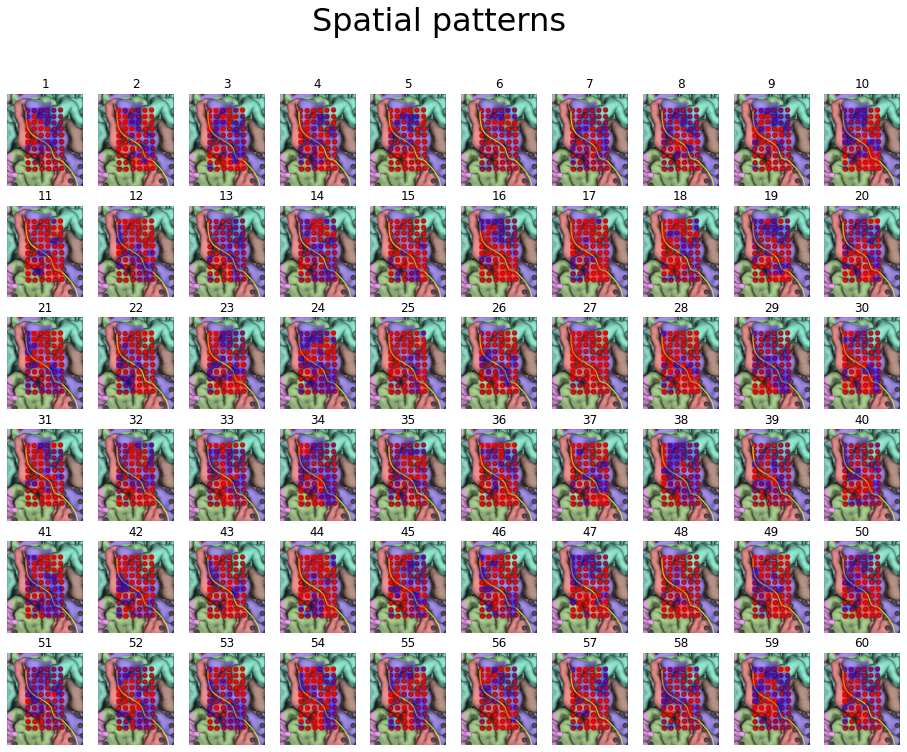

In [21]:
import matplotlib.image as mpimg
from tqdm.auto import tqdm


def plot_patterns(patterns,
                  w=10, h=6,
                  pos=np.array([1., 0., 0.]), neg=np.array([0., 0., 1.]),
                  mul=1.6*1.05, xmul=16, ymul=16,
                  xo=75, yo=57, opacity=0.5,
                  title="Spatial patterns", file_name=None,
                  overlay="brain.png",   # overlay=None,
):
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle(title, fontsize=32)
    xmul, ymul = int(xmul * mul), int(ymul * mul)
    for i, f in enumerate(tqdm(patterns[:h*w])):
        ax = plt.subplot(h, w, i+1)
        ax.axis("off")
        ax.set_title(f"{i + 1}")
        pat = f.reshape((6, 10)).T.copy()
        if overlay is None:
            ax.imshow(pat)
        else:
            im = mpimg.imread(overlay)
            pat -= pat.min()
            pat /= pat.max()
            for y in range(pat.shape[0]):
                for x, e in enumerate(pat[y]):
                    patch = im[y*ymul+yo:(y)*ymul+int(ymul*1.0)+yo, x*xmul+xo:(x+1)*xmul+xo, :3]
                    k = (1 - (1 - abs(e - 0.5) * 2) ** 2) * (1 - opacity) + opacity
                    patch[:, :, :] = patch * k + (pos if e > 0.5 else neg) * (1 - k)
            ax.imshow(im)
    if file_name is not None:
        plt.savefig(file_name)
    plt.show()

plot_patterns(csp.patterns_, file_name="spatial_patterns_on_brain.png")

In [237]:
csp.
for i in range(1, 61):
    plt.subplot(10, 6, )

    csp.patterns_.shape)

(60, 60)


In [219]:
from tqdm.auto import trange


for n_filters in trange(1, 10):
    for start_freq in trange(1,)
    raw.copy().filter()

<RawArray | 60 x 507025 (422.5 s), ~232.2 MB, data loaded>

In [215]:



#%%
# %%

epochs = mne.Epochs(raw, events, tmin=-0.75, tmax=0.75, baseline=(None, 0))
print(epochs)

Not setting metadata
Not setting metadata
90 matching events found
Setting baseline interval to [-0.75, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
<Epochs |  90 events (good & bad), -0.75 - 0.75 sec, baseline -0.75 – 0 sec, ~60 kB, data not loaded,
 '1': 30
 '2': 30
 '3': 30>


Epoch 1
Average


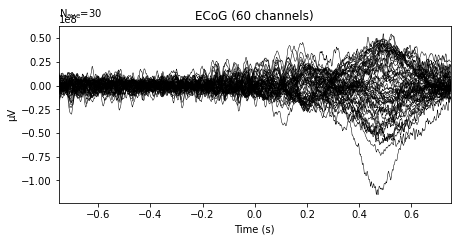

Standard Error


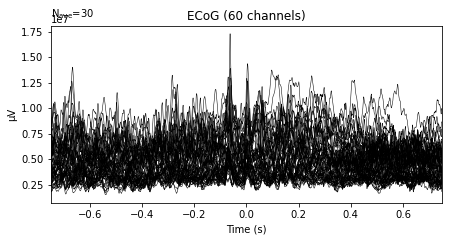

PSD
Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-216-73c6ab1dd755>:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs[i].plot_psd()


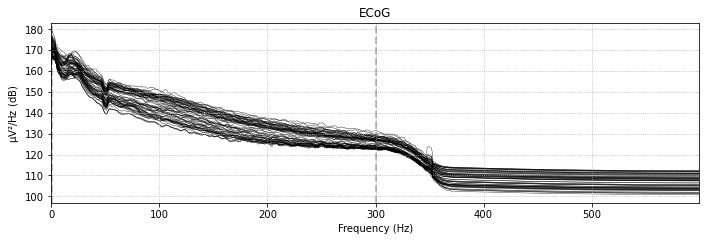

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


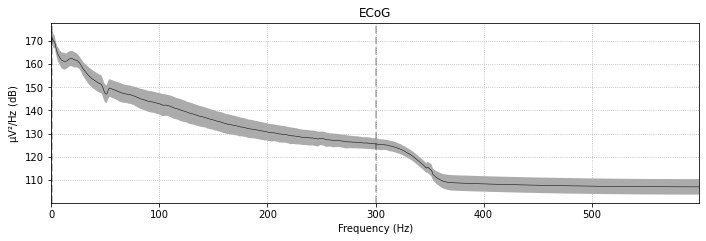

Epoch 2
Average


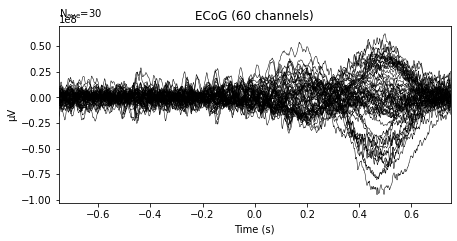

Standard Error


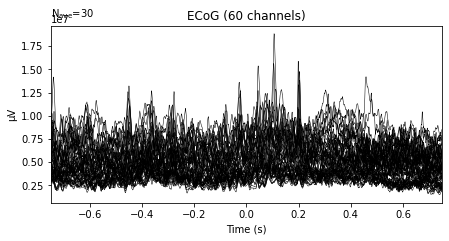

PSD
Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-216-73c6ab1dd755>:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs[i].plot_psd()


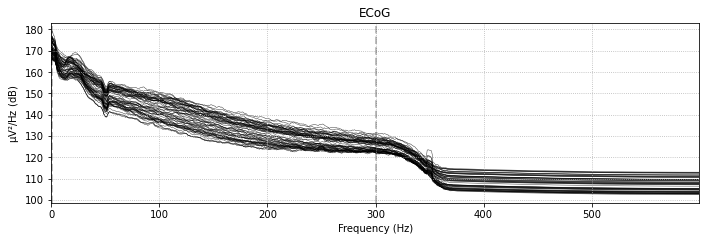

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


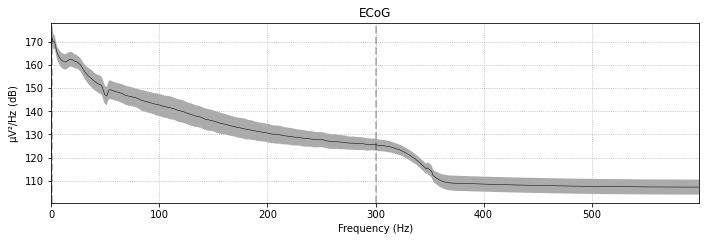

Epoch 3
Average


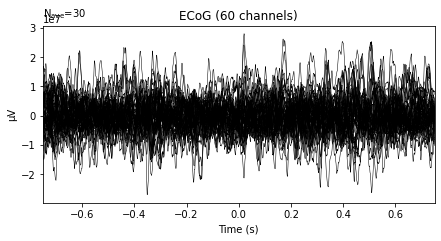

Standard Error


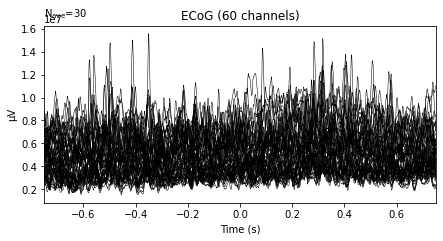

PSD
Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-216-73c6ab1dd755>:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs[i].plot_psd()


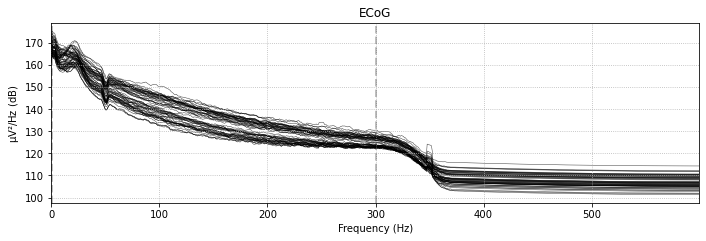

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


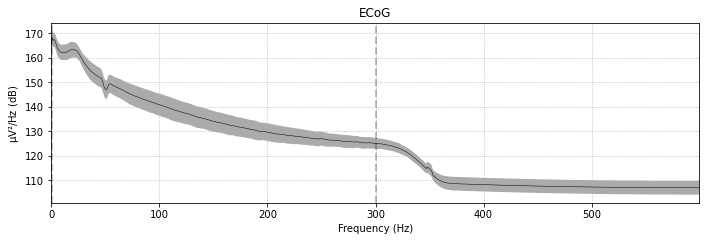

In [216]:
for i in '123':
    print("Epoch", i)
    print("Average")
    evoked = epochs[i].average()
    evoked.plot()
    print("Standard Error")
    epochs[i].standard_error().plot()
    print("PSD")
    epochs[i].plot_psd()
    epochs[i].plot_psd(average=True)

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


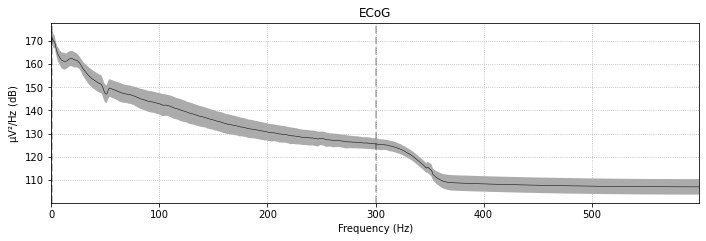

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


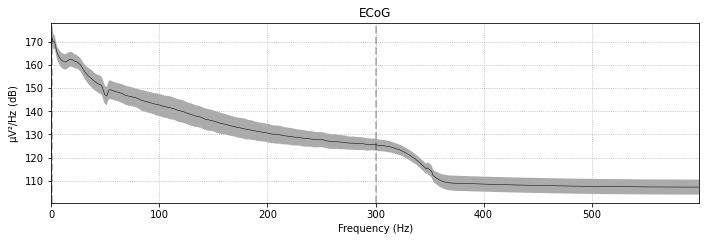

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


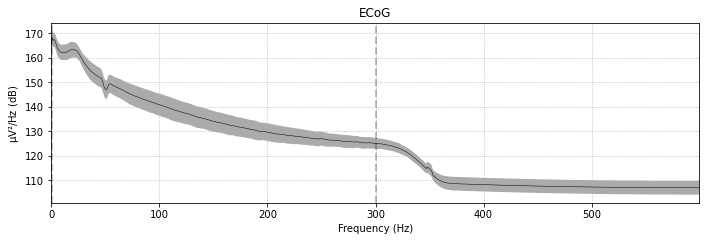

In [217]:
for i in "123":
    epochs[i].plot_psd(average=True)

In [79]:
ev = epochs["3"]
ev
ev.verbose = True

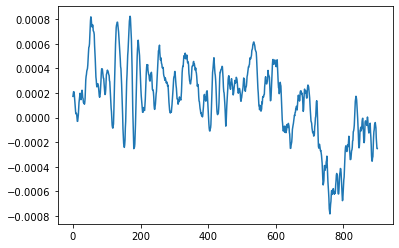

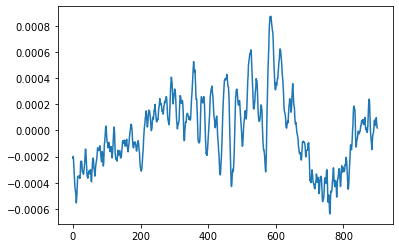

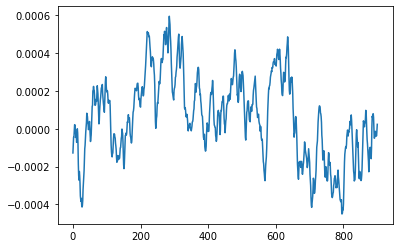

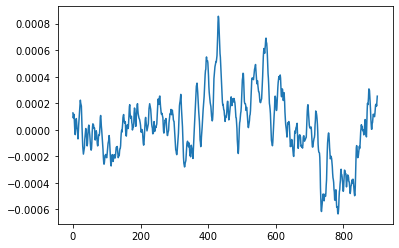

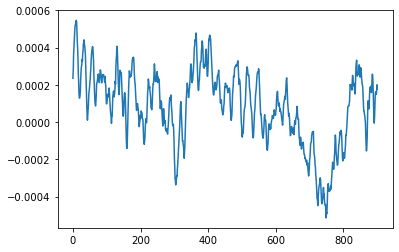

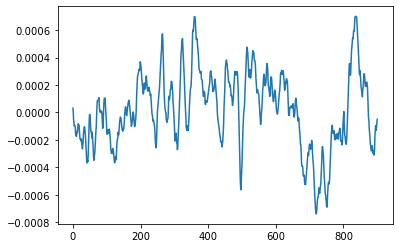

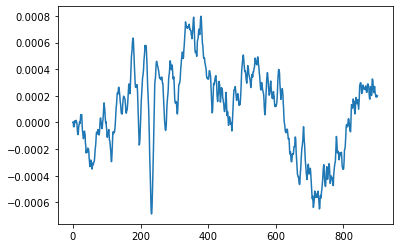

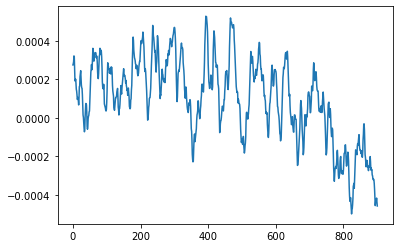

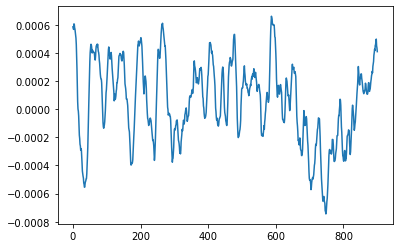

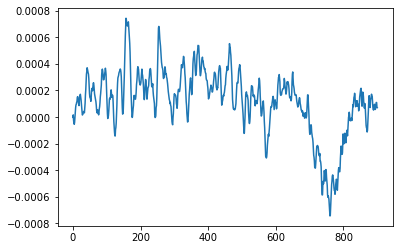

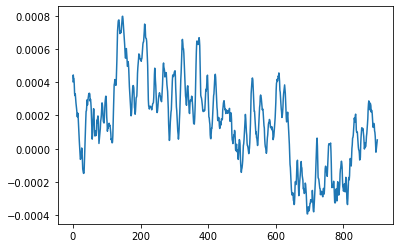

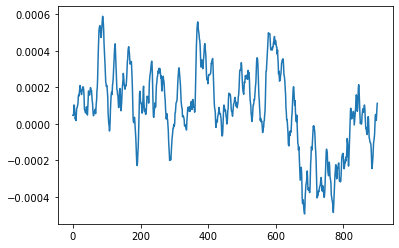

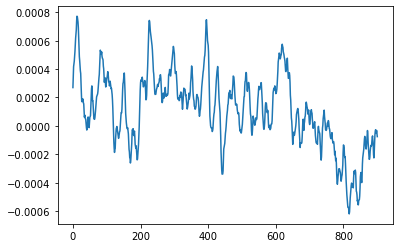

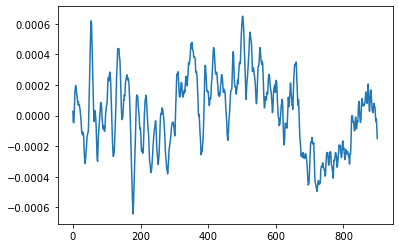

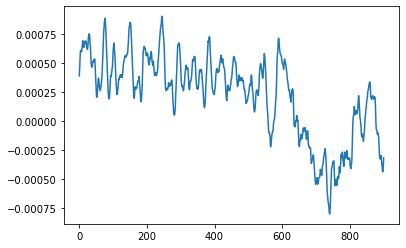

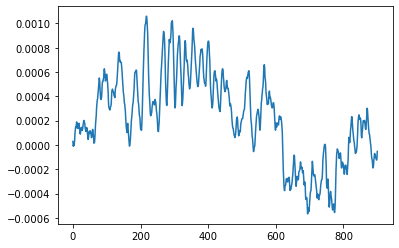

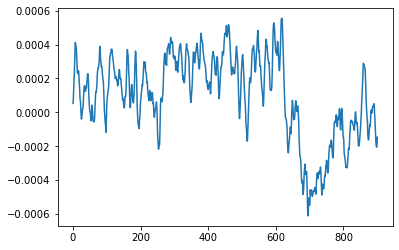

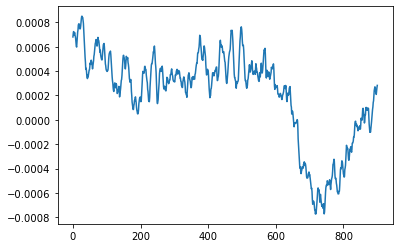

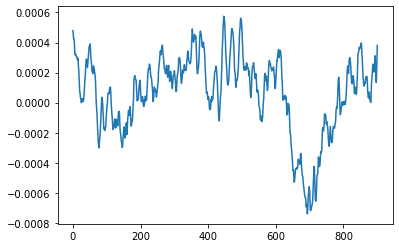

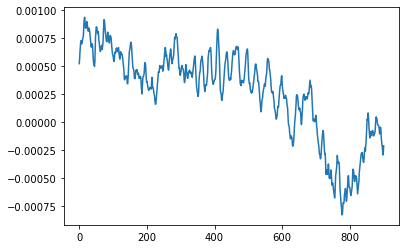

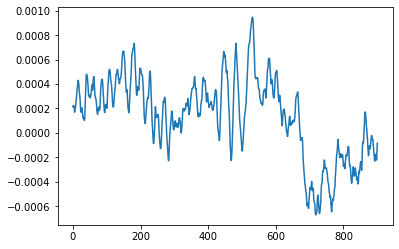

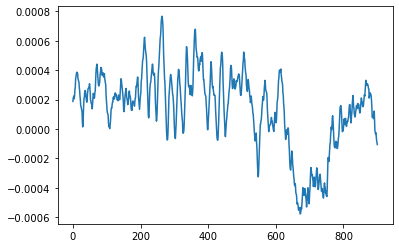

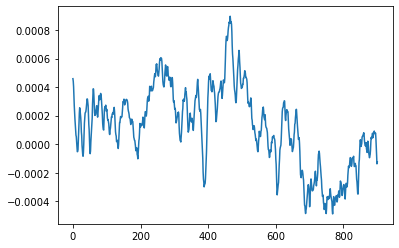

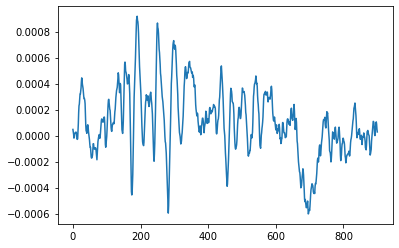

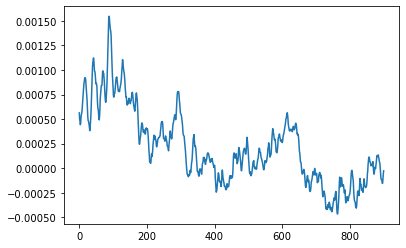

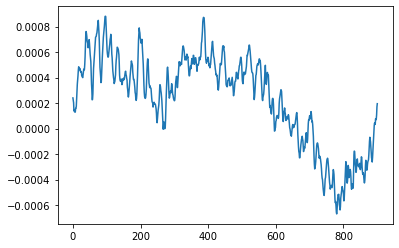

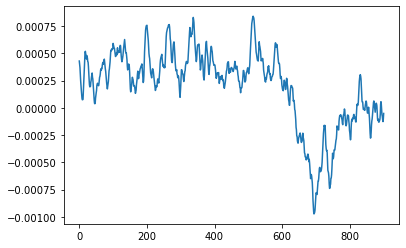

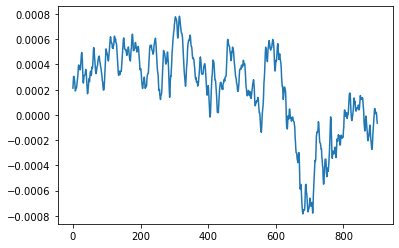

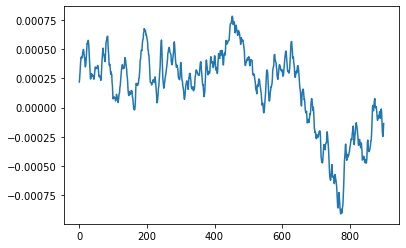

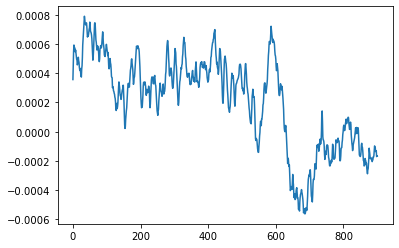

In [87]:
for event in epochs["3"]:
    plt.plot(event.mean(axis=0))
    plt.show()

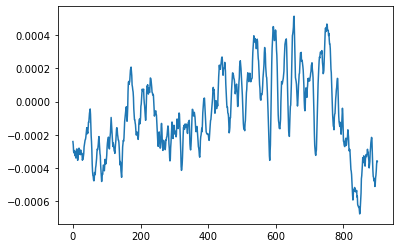

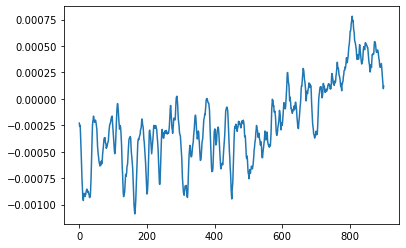

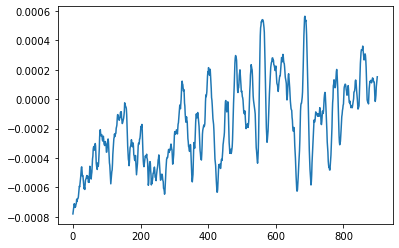

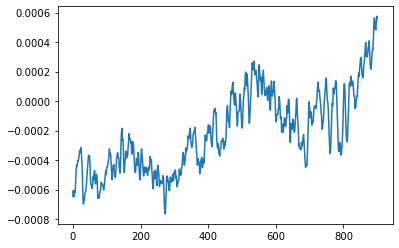

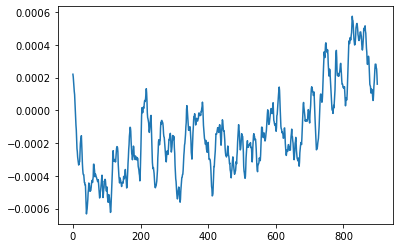

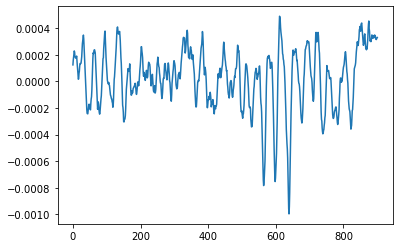

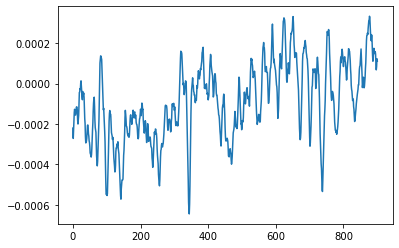

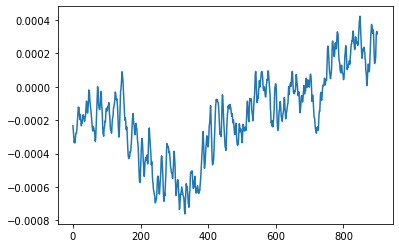

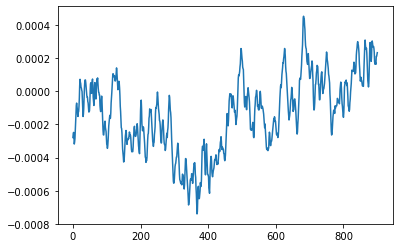

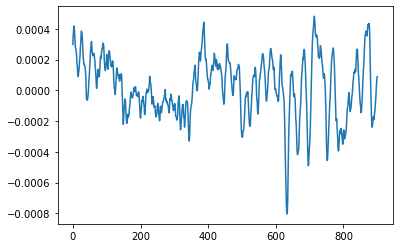

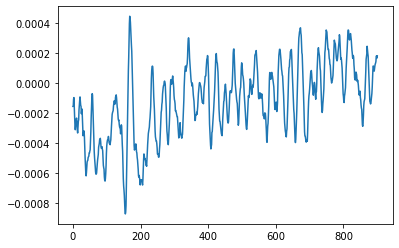

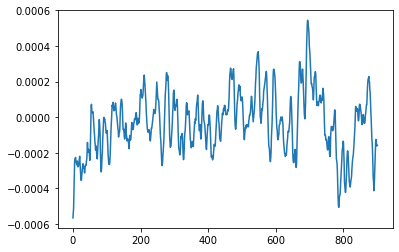

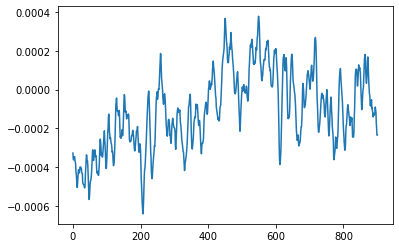

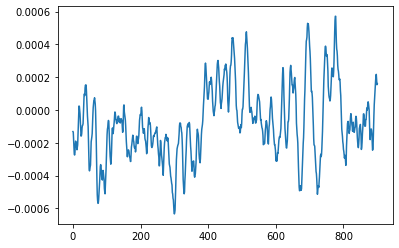

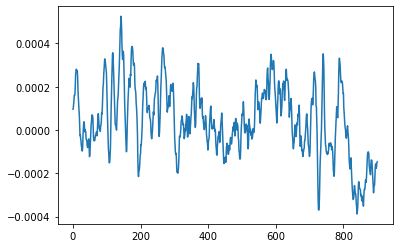

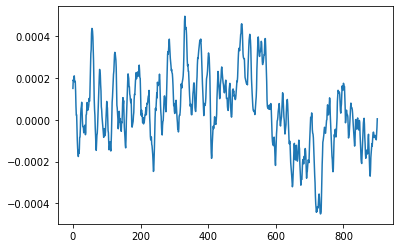

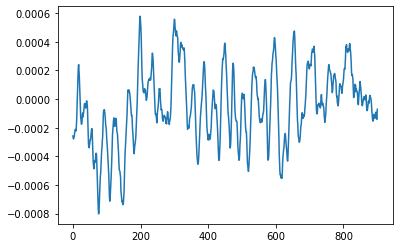

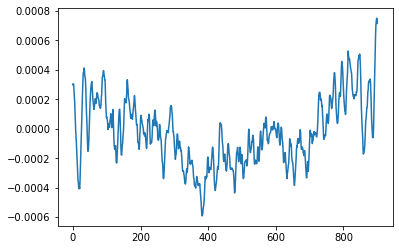

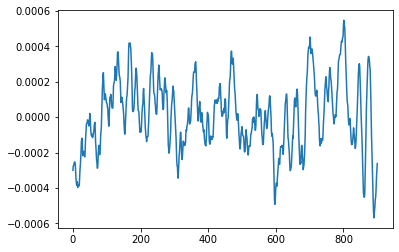

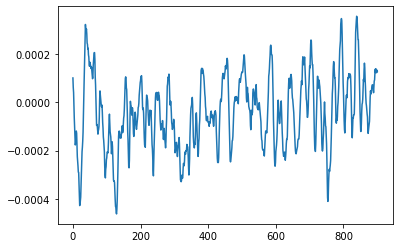

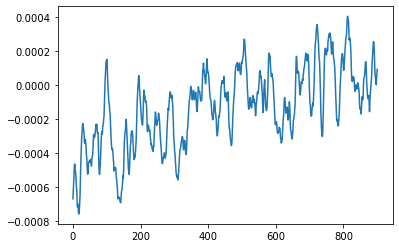

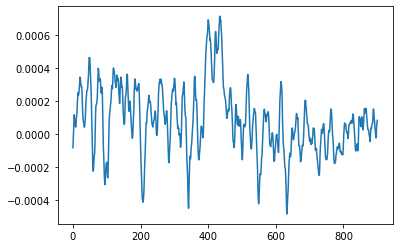

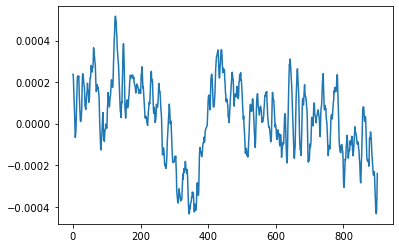

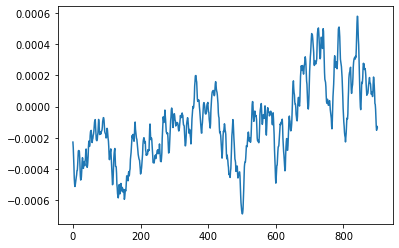

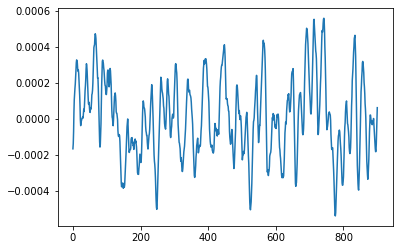

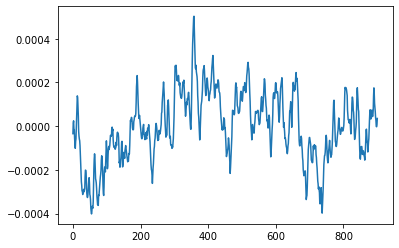

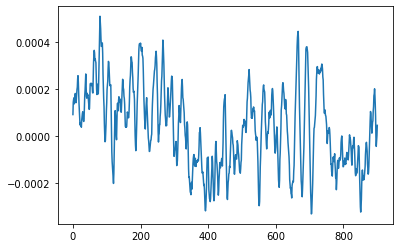

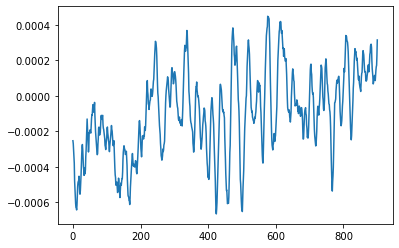

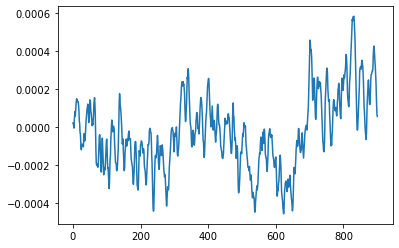

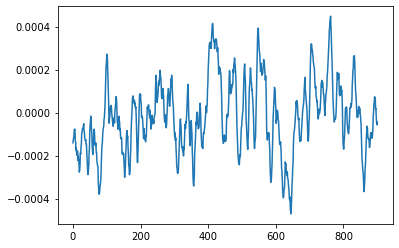

In [88]:
for event in epochs['3']:
    plt.plot(event.mean(axis=0))
    plt.show()

Loading data for 90 events and 1801 original time points ...
0 bad epochs dropped
Loading data for 90 events and 1801 original time points ...
Loading data for 20 events and 1801 original time points ...


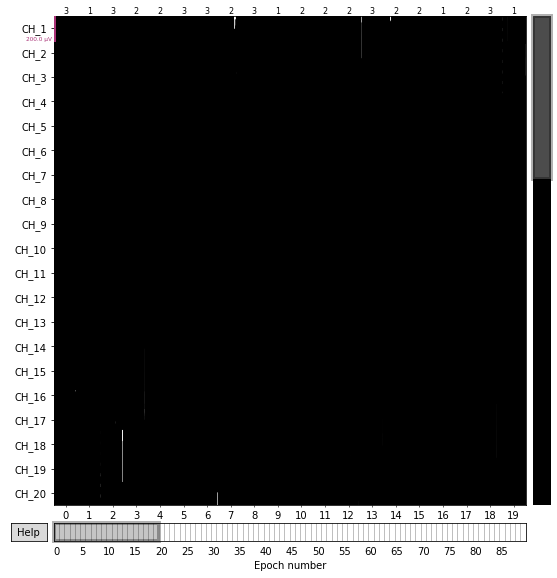

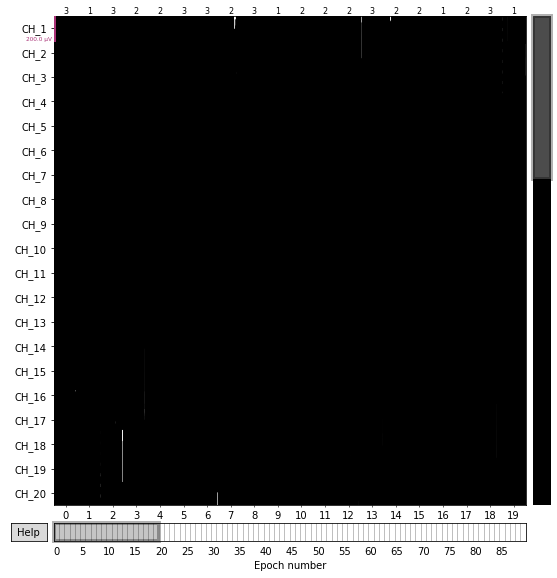

In [61]:
epochs.plot(events=events)

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat


data = loadmat("ECoG_Handpose.mat")

In [2]:
print(data)
y = data["y"]
y.shape

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jun 23 10:38:21 2020', '__version__': '1.0', '__globals__': [], 'y': array([[ 0.00000000e+00,  8.33333333e-04,  1.66666667e-03, ...,
         4.22518333e+02,  4.22519167e+02,  4.22520000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.06701961e+05, -1.06699477e+05, -1.06697859e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.62051094e+04, -8.62023672e+04, -8.61986562e+04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.53902262e-01,  1.53902262e-01,  1.53902262e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.61574081e-01,  1.61574081e-01,  1.61574081e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.34732822e-01,  2.34732822e-01,  2.34732822e-01]])}


(67, 507025)

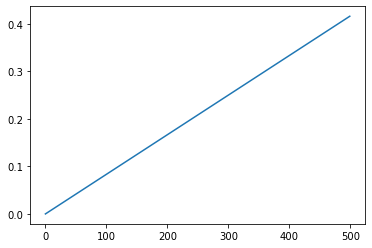

In [3]:
from matplotlib import pyplot as plt


plt.plot(y[0][:500])

In [4]:
df = pd.DataFrame(y.T, columns=["time"] + [f"CH_{i + 1}" for i in range(60)] +
             ['paradigm_info', 'data_glove_thumb', 'data_glove_index', 'data_glove_middle', 'data_glove_ring', 'data_glove_little'])
df

time           CH_1          CH_2          CH_3           CH_4  \
0         0.000000       0.000000      0.000000      0.000000       0.000000   
1         0.000833       0.000000      0.000000      0.000000       0.000000   
2         0.001667       0.000000      0.000000      0.000000       0.000000   
3         0.002500       0.000000      0.000000      0.000000       0.000000   
4         0.003333       0.000000      0.000000      0.000000       0.000000   
...            ...            ...           ...           ...            ...   
507020  422.516667 -106697.578125 -86204.289062 -76535.585938 -103944.351562   
507021  422.517500 -106698.921875 -86203.906250 -76537.109375 -103945.375000   
507022  422.518333 -106701.960938 -86205.109375 -76535.445312 -103945.046875   
507023  422.519167 -106699.476562 -86202.367188 -76532.234375 -103945.843750   
507024  422.520000 -106697.859375 -86198.656250 -76531.257812 -103942.421875   

                CH_5          CH_6          CH_7          CH_8          CH_9  \
0           0.000000      0.000000      0.000000      0.000000      0.000000   
1           0.000000      0.000000      0.000000      0.000000      0.000000   
2           0.000000      0.000000      0.000000      0.000000      0.000000   
3           0.000000      0.000000      0.000000      0.000000      0.000000   
4           0.000000      0.000000      0.000000      0.000000      0.000000   
...              ...           ...           ...           ...           ...   
507020 -59508.328125 -39716.640625 -12350.508789  46311.046875  13856.023438   
507021 -59508.292969 -39717.875000 -12354.244141  46318.351562  13859.705078   
507022 -59511.664062 -39718.042969 -12355.633789  46322.660156  13859.116211   
507023 -59508.625000 -39713.183594 -12354.968750  46326.210938  13862.730469   
507024 -59510.562500 -39712.156250 -12353.298828  46323.835938  13860.594727   

        ...         CH_57         CH_58        CH_59         CH_60  \
0       ...      0.000000      0.000000     0.000000      0.000000   
1       ...      0.000000      0.000000     0.000000      0.000000   
2       ...      0.000000      0.000000     0.000000      0.000000   
3       ...      0.000000      0.000000     0.000000      0.000000   
4       ...      0.000000      0.000000     0.000000      0.000000   
...     ...           ...           ...          ...           ...   
507020  ... -65758.367188 -33892.039062 -4235.358887  51480.582031   
507021  ... -65760.468750 -33896.398438 -4240.333984  51477.101562   
507022  ... -65757.734375 -33894.804688 -4240.388672  51475.777344   
507023  ... -65757.828125 -33896.714844 -4241.463867  51473.503906   
507024  ... -65753.156250 -33894.445312 -4238.678711  51475.753906   

        paradigm_info  data_glove_thumb  data_glove_index  data_glove_middle  \
0                 0.0           0.00000          0.000000           0.000000   
1                 0.0           0.00000          0.000000           0.000000   
2                 0.0           0.00000          0.000000           0.000000   
3                 0.0           0.00000          0.000000           0.000000   
4                 0.0           0.00000          0.000000           0.000000   
...               ...               ...               ...                ...   
507020            0.0           0.70303          0.178975           0.153902   
507021            0.0           0.70303          0.178975           0.153902   
507022            0.0           0.70303          0.178975           0.153902   
507023            0.0           0.70303          0.178975           0.153902   
507024            0.0           0.70303          0.178975           0.153902   

        data_glove_ring  data_glove_little  
0              0.000000           0.000000  
1              0.000000           0.000000  
2              0.000000           0.000000  
3              0.000000           0.000000  
4              0.000000           0.000000  
...                 

<AxesSubplot:>

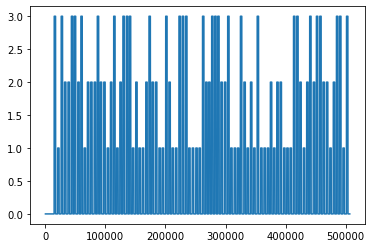

In [14]:
df.paradigm_info.plot()

index              0
paradigm_info    120
dtype: int64


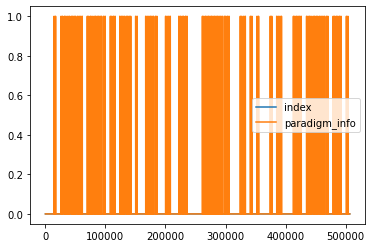

In [23]:
changes = ((df.paradigm_info.iloc[1:].reset_index() - df.paradigm_info.iloc[:-1].reset_index()).abs() > 1).astype("int")
changes.plot()
print(changes.sum())

In [6]:
print(df.data_glove_index.describe())
print(df.paradigm_info.value_counts())

count    507025.000000
mean          0.247886
std           0.301131
min           0.000000
25%           0.075524
50%           0.134398
75%           0.221395
max           1.000000
Name: data_glove_index, dtype: float64
0.0    286801
1.0     73440
2.0     73440
3.0     73344
Name: paradigm_info, dtype: int64


<AxesSubplot:>

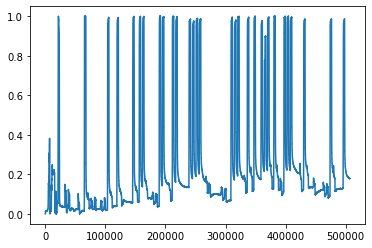

In [7]:
df.data_glove_index.reset_index(drop=True).plot()

<AxesSubplot:>

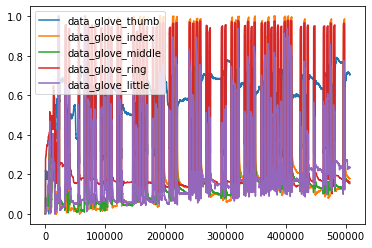

In [8]:
glove_columns = [x for x in df.columns if "glove" in x]
df[glove_columns].plot()

In [26]:
len(df)

507025

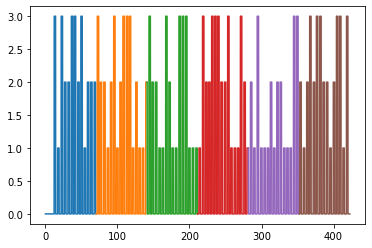

In [24]:
from tqdm.auto import tqdm


n_folds = 8
folds = []
fold_size = len(df) // n_folds
for i in range(0, len(df), fold_size):
    folds.append(df.iloc[i:i+fold_size])
    # folds.append(df.iloc[i//fold_size:].iloc[::fold_size])
for fold in folds:
    plt.plot(fold.time, fold.paradigm_info)

    
def wrap_list(x):
    try:
        len(x)
    except TypeError:
        x = [x]
    return x
    

def percentage_accuracy_score(*args, **kwargs):
    return 100 * sklearn.metrics.accuracy_score(*args, *kwargs)


def cross_fold(models, folds, metrics=percentage_accuracy_score):
    models = wrap_list(models)
    metrics = wrap_list(metrics)
    for model in tqdm(models):
        print(model)
        predicted = []
        true = []
        test_accs = []
        for i, (x_test, y_test) in enumerate(bar := tqdm(folds)):
            x_train, y_train = map(pd.concat, zip(*(folds[:i] + folds[i+1:])))
            model.fit(x_train, y_train)
            y__test = model.predict(x_test)
            predicted.append(y__test)
            true.append(y_test)
            test_acc = percentage_accuracy_score(y_test, y__test)
            test_accs.append(test_acc)
            bar.set_description(f"intermediate accuracy: {test_acc:.4f}, "
                                f"average accuracy: {sum(test_accs) / len(test_accs):.4f}")
        true, predicted = pd.concat(true), np.concatenate(predicted)
        for metric in tqdm(metrics):
            # accuracy decomposes cleanly, but other metrics might not
            print(f"{metric.__name__}: {metric(true, predicted):.4f}")
            
        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true, predicted)
        plt.show()

        for _ in "haha": print()

# Check glove baseline

  0%|          | 0/4 [00:00<?, ?it/s]

DummyClassifier()


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 56.5655


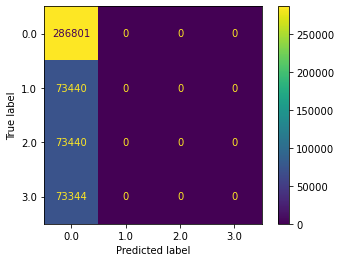





KNeighborsClassifier(n_neighbors=3)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 58.0676


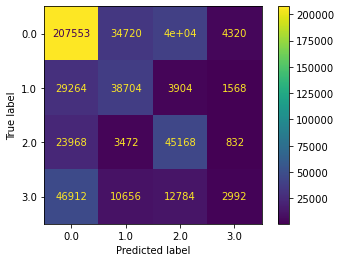





KNeighborsClassifier(n_neighbors=11)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 58.0676


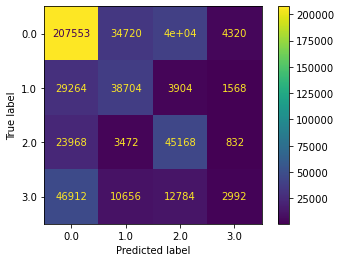





SGDClassifier()


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 71.0152


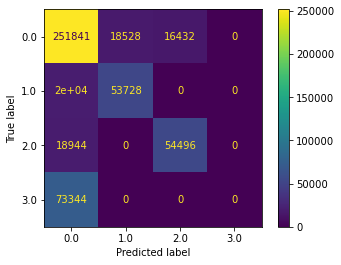

In [25]:
import sklearn
import sklearn.dummy  # not sure why it's not there by default
import sklearn.neighbors


model_templates = [
          sklearn.dummy.DummyClassifier(),
          sklearn.neighbors.KNeighborsClassifier(n_neighbors=3),
          sklearn.neighbors.KNeighborsClassifier(n_neighbors=11),
          sklearn.linear_model.SGDClassifier(),
          # sklearn.svm.SVC(kernel="rbf"),
          # sklearn.svm.SVC(kernel="poly"),
          # sklearn.svm.SVC(kernel="gaussian")
]
cross_fold(model_templates,
           [[fold[glove_columns], fold.paradigm_info] for fold in folds])

In [ ]:

cross_fold(model_templates,
           [[fold[glove_columns], fold.paradigm_info] for fold in folds])

# TODO
* Calculate trial info
* Try random Cross-Validation
* Import into MNE
* Use Catboost
* Use real features
* Windowed features
* Band-power
* Filtering
* TDA

In [12]:
1/0

ZeroDivisionError: division by zero